In [1]:

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

In [2]:
%load_ext autoreload
%autoreload 2

from bs_helpers import *
from bs_gameclass import *
from utils import *

In [3]:
net = bs_unet()
#net.load_state_dict(torch.load('data/battleships_unet.dat'))
net.optim = torch.optim.Adam(lr=0.001, betas=(0., 0.999), params=net.parameters())

In [4]:
gamma = 0.8

In [5]:
def batchgen(games, size, verbose=1):
    
    while True:
        indlist = np.random.permutation(range(len(games)))
        minibatches = [ indlist[k*size:(k+1)*size] for k in range(len(indlist)//size) ]
        
        for mb in minibatches:
            xs = np.zeros((size, SX, SY, 3))
            ys = np.zeros((size, SX, SY, 1))
            rs = np.zeros((size))
            for k, l in enumerate(mb):
                s, (i,j), qmax, r = games[l]
                xs[k] = encode_x(s.sea, s.det)
                ys[k, i, j] = 1.
                if np.random.rand()<.5:
                    xs[k] = xs[k,:,::-1]
                    ys[k] = ys[k,:,::-1]
                if np.random.rand()<.5:
                    xs[k] = xs[k,::-1]
                    ys[k] = ys[k,::-1]
                if np.random.rand()<.5:
                    xs[k] = xs[k].transpose(1,0,2)
                    ys[k] = ys[k].transpose(1,0,2)
                rs[k] = r + gamma*qmax
            yield xs, ys, rs
        if verbose:
            print('Finished one batchgen epoch!')

In [8]:

for epoch in range(9999999):

    # Play some games
    games = []
    glengths = []
    slast = 0
    for _ in trange(100):
        s = GameState()
        h = create_sea()
        single_game = []
        while not GameClass.getEnded(s):
            #plot_sea(s.sea, s.det)
            #plt.show()
            net.predict(encode_x(s.sea, s.det))
            Qa = t2np(net.p[0,:,:,0])   # p ist der pre activation output des unets
            i, j = argmax2d(Qa-10000*s.det)
            Qmax = np.max(Qa)
            if np.random.rand() < 0.1:
                vms = GameClass.getValidActions(s)
                l = np.random.choice(len(vms))
                i, j = vms[l]
            r = h[i,j] # reward
            
            if slast:
                single_game.append((slast, alast, Qmax, rlast))
            slast = s
            alast = (i, j)
            rlast = r
            
            s = GameClass.getNextState(s, (i,j), hidden=h)
        games += single_game
        '''
        # Cumulate reward
        cr = 0.
        for s, (i,j), r in reversed(single_game):
            cr = gamma*cr + r
            games.append((s, (i,j), cr))'''
        glengths.append(len(single_game))
    
    print('Game length mean', np.mean(glengths))
    
    
    # train the nnet
    bg = batchgen(games, size=32)
    losses = []
    
    #raise
    for k in trange(1000): 
        xs, ys, qs = next(bg)
        xs, ys, qs = np2t(xs, ys, qs)
        net(xs)
        qp = net.p
        qp = torch.sum(qp * ys, dim=(1,2,3))
        loss = torch.mean((qp-qs)**2)
        #print(loss)
        loss.backward()
        net.optim.step()
        net.optim.zero_grad()
        losses.append(loss.item())
        if k%100 == 0:
            print(np.mean(losses))
            losses = []
            
    torch.save(net.state_dict(), 'model_qlearning.dat')

  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 79.19


  0%|          | 0/1000 [00:00<?, ?it/s]

0.18112334609031677
0.2247117839753628
0.22469143584370613
Finished one batchgen epoch!
0.2253901980817318
0.22012798339128495
Finished one batchgen epoch!
0.2191365970671177
0.21947215497493744
0.22345383942127228
Finished one batchgen epoch!
0.21254654541611673
0.22149455435574056
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 74.91


  0%|          | 0/1000 [00:00<?, ?it/s]

0.3450666069984436
0.24068114653229714
0.24699530854821206
Finished one batchgen epoch!
0.23423054605722426
0.2419198025763035
Finished one batchgen epoch!
0.2354511673748493
0.23544474706053733
0.24364708989858627
Finished one batchgen epoch!
0.2395779450237751
0.23795141726732255
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 78.6


  0%|          | 0/1000 [00:00<?, ?it/s]

0.23277592658996582
0.22345100186765193
0.22440671429038048
Finished one batchgen epoch!
0.2279966527223587
0.21971023447811602
Finished one batchgen epoch!
0.22106602564454078
0.21902278304100037
0.21932330295443536
Finished one batchgen epoch!
0.22131026312708854
0.2214755369722843
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 78.13


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2012300193309784
0.22384769722819328
0.2351370197534561
Finished one batchgen epoch!
0.23163060039281846
0.22766012996435164
Finished one batchgen epoch!
0.22726123839616774
0.22057486034929752
0.22702775582671164
Finished one batchgen epoch!
0.2352306441962719
0.22592109322547912
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 78.27


  0%|          | 0/1000 [00:00<?, ?it/s]

0.29281190037727356
0.23506880588829518
0.2347426238656044
Finished one batchgen epoch!
0.23119267493486403
0.22290160931646824
Finished one batchgen epoch!
0.23213841378688813
0.22275015771389006
0.2279313860833645
Finished one batchgen epoch!
0.22654563054442406
0.22639341846108438
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 78.25


  0%|          | 0/1000 [00:00<?, ?it/s]

0.24725273251533508
0.22880531042814256
0.23480710998177529
Finished one batchgen epoch!
0.22975910738110542
0.22715715743601322
Finished one batchgen epoch!
0.234377598464489
0.22029185846447943
0.23428955882787705
Finished one batchgen epoch!
0.2281450954079628
0.22986963003873825
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 75.93


  0%|          | 0/1000 [00:00<?, ?it/s]

0.29702335596084595
0.23955629050731658
0.23596002131700516
Finished one batchgen epoch!
0.23798617109656334
0.23345052912831307
Finished one batchgen epoch!
0.24007329866290092
0.22994000673294068
0.23490388974547385
Finished one batchgen epoch!
0.2261827039718628
0.23922133669257165
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.93


  0%|          | 0/1000 [00:00<?, ?it/s]

0.17815551161766052
0.23613782040774822
0.23111640140414239
Finished one batchgen epoch!
0.23217134088277816
0.23026503652334213
Finished one batchgen epoch!
0.22795533984899521
0.22085561588406563
0.23179517880082132
Finished one batchgen epoch!
0.2291499598324299
0.22818401083350182
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 77.8


  0%|          | 0/1000 [00:00<?, ?it/s]

0.18997249007225037
0.23079199701547623
0.23151332825422288
Finished one batchgen epoch!
0.23354091092944146
0.22665827646851539
Finished one batchgen epoch!
0.2338702042400837
0.2280593430995941
0.2344890935719013
Finished one batchgen epoch!
0.23031748905777932
0.22547969974577428
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.74


  0%|          | 0/1000 [00:00<?, ?it/s]

0.20360532402992249
0.228039520829916
0.23077598616480827
Finished one batchgen epoch!
0.23310259416699408
0.23704658672213555
Finished one batchgen epoch!
0.22558523565530778
0.22553703993558882
0.23383556112647055
Finished one batchgen epoch!
0.22680019669234752
0.2330539520084858
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.35


  0%|          | 0/1000 [00:00<?, ?it/s]

0.20594342052936554
0.24561247497797012
0.2318148398399353
Finished one batchgen epoch!
0.24148827388882638
0.23007995143532753
Finished one batchgen epoch!
0.24077097058296204
0.23746022909879685
0.23550326377153397
Finished one batchgen epoch!
0.2334728480875492
0.2366502510011196
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 78.77


  0%|          | 0/1000 [00:00<?, ?it/s]

0.21516498923301697
0.22288672626018524
0.2255131983757019
Finished one batchgen epoch!
0.21495004288852215
0.22489329561591148
Finished one batchgen epoch!
0.21301221415400506
0.2251136665046215
0.21257345542311668
Finished one batchgen epoch!
0.2183873514086008
0.22054532840847968
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 77.64


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2020685374736786
0.22419552445411683
0.22491119623184205
Finished one batchgen epoch!
0.22664620324969292
0.22295357018709183
Finished one batchgen epoch!
0.22302212059497833
0.22141949623823165
0.22178370594978333
Finished one batchgen epoch!
0.22527973100543022
0.21963171541690826
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 75.78


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2563594579696655
0.23118516251444818
0.22591968595981599
Finished one batchgen epoch!
0.22709638461470605
0.22842979609966277
Finished one batchgen epoch!
0.2284565019607544
0.22164874359965325
0.2278769840300083
Finished one batchgen epoch!
0.21673677586019038
0.2253244212269783
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.74


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2307203710079193
0.3901860435307026
0.22914321169257165
Finished one batchgen epoch!
0.22347322255373
0.21966702237725258
Finished one batchgen epoch!
0.21825712248682977
0.22328175738453865
0.22058772757649422
Finished one batchgen epoch!
0.22162208944559098
0.2219887126982212
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.4


  0%|          | 0/1000 [00:00<?, ?it/s]

0.1877681314945221
0.23076072350144386
0.23012210592627524
Finished one batchgen epoch!
0.22282692030072213
0.22540398746728896
Finished one batchgen epoch!
0.2243515110015869
0.2243402913212776
0.22388655588030815
Finished one batchgen epoch!
0.22528655365109443
0.22709295853972436
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.2


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2260298728942871
0.23701273024082184
0.23189229041337966
Finished one batchgen epoch!
0.22971017226576806
0.22640094995498658
Finished one batchgen epoch!
0.23665727108716964
0.22834691554307937
0.22744655460119248
Finished one batchgen epoch!
0.23257425382733346
0.2211140263825655
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.41


  0%|          | 0/1000 [00:00<?, ?it/s]

0.31411466002464294
0.23628958702087402
0.2295587606728077
Finished one batchgen epoch!
0.22679537378251552
0.22831574812531472
Finished one batchgen epoch!
0.23416710048913955
0.23136438503861428
0.22424750477075578
Finished one batchgen epoch!
0.22760278865695
0.22639493882656098
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 77.57


  0%|          | 0/1000 [00:00<?, ?it/s]

0.18963420391082764
0.22078230157494544
0.21920810006558894
Finished one batchgen epoch!
0.22441450655460357
0.21745038598775865
Finished one batchgen epoch!
0.22633125700056553
0.22034818544983864
0.21991077035665513
Finished one batchgen epoch!
0.22150653839111328
0.22081215173006058
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.17


  0%|          | 0/1000 [00:00<?, ?it/s]

0.25819242000579834
0.21412347078323365
0.22209002010524273
Finished one batchgen epoch!
0.2210586741566658
0.21959054082632065
Finished one batchgen epoch!
0.22252168297767638
0.2240974622964859
0.2137991075217724
Finished one batchgen epoch!
0.21504141435027121
0.21927487924695016
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 78.78


  0%|          | 0/1000 [00:00<?, ?it/s]

0.20323646068572998
0.2197272728383541
0.21059671051800252
Finished one batchgen epoch!
0.22314577408134936
0.21166405960917473
Finished one batchgen epoch!
0.21116339817643165
0.21588529951870442
0.2113906879723072
Finished one batchgen epoch!
0.20777954377233981
0.21219330593943597
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 74.74


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2181459367275238
0.22251828759908676
0.23268612638115882
Finished one batchgen epoch!
0.2131437638401985
0.21997098542749882
Finished one batchgen epoch!
0.2259365439414978
2.2287980280816555
Finished one batchgen epoch!
0.23264535814523696
0.22470709994435312
0.2195607043802738
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 78.5


  0%|          | 0/1000 [00:00<?, ?it/s]

0.17239105701446533
0.21665267184376716
0.21423541605472565
Finished one batchgen epoch!
0.21244209736585618
0.20978500977158546
Finished one batchgen epoch!
0.21547101438045502
0.21425157777965068
0.21249055489897728
Finished one batchgen epoch!
0.21041369028389453
0.21684755265712738
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.69


  0%|          | 0/1000 [00:00<?, ?it/s]

0.1382787525653839
0.21866573244333268
0.21992164462804795
Finished one batchgen epoch!
0.21973418235778808
0.2152025133371353
Finished one batchgen epoch!
0.21603485316038132
0.21927384786307813
0.2180645437538624
Finished one batchgen epoch!
0.2168249251693487
0.21710519775748252
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 80.08


  0%|          | 0/1000 [00:00<?, ?it/s]

0.19721069931983948
0.21279290020465852
0.21543763943016528
Finished one batchgen epoch!
0.19856433786451816
0.21406896218657492
Finished one batchgen epoch!
0.2059840515255928
0.20580826237797736
0.2059857489168644
Finished one batchgen epoch!
0.20779189847409726
0.20913509599864483


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.55


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2343549132347107
0.22689594596624374
0.21851833820343017
Finished one batchgen epoch!
0.21756571829319
0.2238905955851078
Finished one batchgen epoch!
0.22246794894337654
0.215754614174366
0.22422564640641213
Finished one batchgen epoch!
0.22135300800204277
0.2108230895549059
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 77.01


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2600848078727722
0.21771088540554046
0.21803974196314813
Finished one batchgen epoch!
0.21841709747910498
0.21614871643483638
Finished one batchgen epoch!
0.21554788202047348
0.2108753241598606
0.21815548598766327
Finished one batchgen epoch!
0.21225763112306595
0.21837015688419342
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.91


  0%|          | 0/1000 [00:00<?, ?it/s]

0.17492085695266724
0.2226404793560505
0.2223580914735794
Finished one batchgen epoch!
0.22400650337338449
0.21453764580190182
Finished one batchgen epoch!
0.2217396928369999
0.2197986797988415
0.2229675604403019
Finished one batchgen epoch!
0.22106969341635704
0.2235099694132805
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 75.37


  0%|          | 0/1000 [00:00<?, ?it/s]

0.22168031334877014
0.22575184389948844
0.22216424718499184
Finished one batchgen epoch!
0.2164677269756794
0.22129684016108514
Finished one batchgen epoch!
0.219357920140028
0.22402130499482154
0.21493455454707144
Finished one batchgen epoch!
0.2165738423168659
0.2226970387995243
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.17


  0%|          | 0/1000 [00:00<?, ?it/s]

0.1745086908340454
0.22793414667248726
0.22435326382517815
Finished one batchgen epoch!
0.22446273133158684
0.22609713301062584
Finished one batchgen epoch!
0.22205116212368012
0.22177836894989014
0.2264861086010933
Finished one batchgen epoch!
0.22312167167663574
0.22407984755933286
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.89


  0%|          | 0/1000 [00:00<?, ?it/s]

0.1790226846933365
0.21241832450032233
0.21565153762698175
Finished one batchgen epoch!
0.21505470529198648
0.20933922365307808
Finished one batchgen epoch!
0.2083990043401718
0.21215921700000762
0.21232279598712922
Finished one batchgen epoch!
0.211061722189188
0.2107821898162365
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 75.79


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2097684144973755
0.226666684448719
0.2299354502558708
Finished one batchgen epoch!
0.22189129188656806
0.22784029051661492
Finished one batchgen epoch!
0.22534768804907798
0.22591191843152048
0.2254937106370926
Finished one batchgen epoch!
0.22205104410648346
0.22442977994680405
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 75.91


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2468452751636505
0.22096384316682816
0.2105577829480171
Finished one batchgen epoch!
0.21733260199427604
0.22055984944105148
Finished one batchgen epoch!
0.20262468978762627
0.21614804215729236
0.21619454830884932
Finished one batchgen epoch!
0.21367572233080864
0.2156383942067623
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 74.68


  0%|          | 0/1000 [00:00<?, ?it/s]

0.16688114404678345
0.21864646404981614
0.22323154360055925
Finished one batchgen epoch!
0.2195914575457573
0.2224142825603485
Finished one batchgen epoch!
0.21508343786001205
0.21964431278407573
Finished one batchgen epoch!
0.22400283724069595
0.22201353222131728
0.21335181325674057
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 77.32


  0%|          | 0/1000 [00:00<?, ?it/s]

0.21811366081237793
0.2132507625222206
0.22775390937924386
Finished one batchgen epoch!
0.21524678483605386
0.21928508535027505
Finished one batchgen epoch!
0.21589579477906226
0.21651900812983513
0.2120532648265362
Finished one batchgen epoch!
0.2159269431233406
0.2197192934155464
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 75.55


  0%|          | 0/1000 [00:00<?, ?it/s]

0.258480429649353
0.22078537553548813
0.22767735734581948
Finished one batchgen epoch!
0.22137802720069885
0.22031892135739325
Finished one batchgen epoch!
0.2225127911567688
0.22305145785212516
0.21625596404075623
Finished one batchgen epoch!
0.2163451173901558
0.2234462134540081
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 75.35


  0%|          | 0/1000 [00:00<?, ?it/s]

0.1977136880159378
0.2182988367974758
0.22589178547263145
Finished one batchgen epoch!
0.2262300942838192
0.21961954966187477
Finished one batchgen epoch!
0.2161311450600624
0.2189888446033001
0.22106376066803932
Finished one batchgen epoch!
0.22251223176717758
0.21471352696418763
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 74.29


  0%|          | 0/1000 [00:00<?, ?it/s]

0.22012607753276825
0.22286676973104477
0.21601498126983643
Finished one batchgen epoch!
0.22073763713240624
0.2203056203573942
Finished one batchgen epoch!
0.21980714723467826
0.21941078677773476
Finished one batchgen epoch!
0.21975046053528785
0.22288024000823498
0.2153939412534237
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 78.06


  0%|          | 0/1000 [00:00<?, ?it/s]

0.29182296991348267
0.21213513016700744
0.20683530896902083
Finished one batchgen epoch!
0.2091047266125679
0.2065374932438135
Finished one batchgen epoch!
0.2104359260201454
0.20911187283694743
0.20536998383700847
Finished one batchgen epoch!
0.20350369647145272
0.20968960396945477
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 74.75


  0%|          | 0/1000 [00:00<?, ?it/s]

0.21745514869689941
0.22107949495315551
0.2253754308819771
Finished one batchgen epoch!
0.22586481302976608
0.22335053682327272
Finished one batchgen epoch!
0.22365342259407042
0.22494295343756676
Finished one batchgen epoch!
0.21917906522750855
0.22167176738381386
0.22448886394500733
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.31


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2356002777814865
0.21818174555897712
0.21606539115309714
Finished one batchgen epoch!
0.21787850692868233
0.21765868306159974
Finished one batchgen epoch!
0.2140057560801506
0.21380835101008416
0.21058549493551254
Finished one batchgen epoch!
0.21504487037658693
0.2138729514181614
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 75.52


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2790223956108093
0.22092558935284615
0.21973770081996918
Finished one batchgen epoch!
0.22146916329860689
0.22204496517777442
Finished one batchgen epoch!
0.21573148116469384
0.22026319555938245
0.22429144158959388
Finished one batchgen epoch!
0.22715038403868676
0.22044888593256473
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 77.75


  0%|          | 0/1000 [00:00<?, ?it/s]

0.19971388578414917
0.2212899509072304
0.22023367613554
Finished one batchgen epoch!
0.21701055720448495
0.2207539378106594
Finished one batchgen epoch!
0.2158297261595726
0.21835088282823562
0.21521903537213802
Finished one batchgen epoch!
0.21938812375068664
0.21777998991310596
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 75.98


  0%|          | 0/1000 [00:00<?, ?it/s]

0.22342482209205627
0.21936567023396492
0.22724993973970414
Finished one batchgen epoch!
0.22330280750989914
0.22255639895796775
Finished one batchgen epoch!
0.2223168821632862
0.22196666114032268
0.22090700551867484
Finished one batchgen epoch!
0.2166964416950941
0.22205358907580375
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 79.65


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2717761993408203
0.20631809905171394
0.20290358431637287
Finished one batchgen epoch!
0.20059265449643135
0.1995260325074196
Finished one batchgen epoch!
0.20597604051232338
0.19981762006878853
0.20215884745121002
Finished one batchgen epoch!
0.20121505357325076
0.1975500363111496
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.52


  0%|          | 0/1000 [00:00<?, ?it/s]

0.20274300873279572
0.22012388154864312
0.22085365168750287
Finished one batchgen epoch!
0.21868892669677734
0.21607123225927352
Finished one batchgen epoch!
0.21591538667678833
0.22427575305104255
0.21247308120131492
Finished one batchgen epoch!
0.20701369136571884
0.21935231253504753
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.39


  0%|          | 0/1000 [00:00<?, ?it/s]

0.1930471509695053
0.22576287671923637
0.21465767547488213
Finished one batchgen epoch!
0.2090121877938509
0.22052673131227493
Finished one batchgen epoch!
0.21649790346622466
0.21052160665392874
0.21791544809937477
Finished one batchgen epoch!
0.2144216600060463
0.21672309666872025
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.81


  0%|          | 0/1000 [00:00<?, ?it/s]

0.1878422349691391
0.22798120200634003
0.21561480700969696
Finished one batchgen epoch!
0.22392303109169007
0.22237091675400733
Finished one batchgen epoch!
0.2208140605688095
0.22217961862683297
0.21910545617341995
Finished one batchgen epoch!
0.22115915447473525
0.21235518388450145
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.7


  0%|          | 0/1000 [00:00<?, ?it/s]

0.18170614540576935
0.2202835711836815
0.22400173768401146
Finished one batchgen epoch!
0.2182414448261261
0.21439421847462653
Finished one batchgen epoch!
0.2149716366827488
0.21922833263874053
0.21726543843746185
Finished one batchgen epoch!
0.211857920140028
0.21695510283112526
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.02


  0%|          | 0/1000 [00:00<?, ?it/s]

0.25828009843826294
0.2210280679911375
0.2194311847537756
Finished one batchgen epoch!
0.2172174087166786
0.2179759331047535
Finished one batchgen epoch!
0.2149412886798382
0.21673959091305733
0.21957556992769242
Finished one batchgen epoch!
0.2178953231871128
0.41516220934689047
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 78.98


  0%|          | 0/1000 [00:00<?, ?it/s]

0.22740551829338074
0.2122888118773699
0.22350138261914254
Finished one batchgen epoch!
0.21222371369600296
0.21286741226911546
Finished one batchgen epoch!
0.21881312236189843
0.21191833019256592
0.20969478338956832
Finished one batchgen epoch!
0.2205652943253517
0.2094924796372652
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 75.26


  0%|          | 0/1000 [00:00<?, ?it/s]

0.22036123275756836
0.22752508908510208
0.22599025294184685
Finished one batchgen epoch!
0.22539483830332757
0.23024765089154242
Finished one batchgen epoch!
0.22915548890829085
0.22921055808663368
0.22683808833360672
Finished one batchgen epoch!
0.22272513702511787
0.22487927988171577
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 75.41


  0%|          | 0/1000 [00:00<?, ?it/s]

0.24270965158939362
0.22486577242612837
0.2212249755859375
Finished one batchgen epoch!
0.22245413586497306
0.2158669775724411
Finished one batchgen epoch!
0.22978778705000877
0.22540137007832528
0.221906106621027
Finished one batchgen epoch!
0.2173408429324627
0.22842373922467232
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.95


  0%|          | 0/1000 [00:00<?, ?it/s]

0.20925076305866241
0.2162350395321846
0.215996757671237
Finished one batchgen epoch!
0.2124371522665024
0.2140067371726036
Finished one batchgen epoch!
0.2104056505858898
0.20958366096019745
0.21492604553699493
Finished one batchgen epoch!
0.20924609430134297
0.2115657524764538
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 77.08


  0%|          | 0/1000 [00:00<?, ?it/s]

0.1681516468524933
0.21586364954710008
0.21551209837198257
Finished one batchgen epoch!
0.2163612262904644
0.2114290963113308
Finished one batchgen epoch!
0.2101630362123251
0.21674651592969896
0.2072354331612587
Finished one batchgen epoch!
0.20937622621655463
0.21419306501746177
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.45


  0%|          | 0/1000 [00:00<?, ?it/s]

0.23547032475471497
0.22277507677674294
0.22259842917323114
Finished one batchgen epoch!
0.22460291564464568
0.2220082961022854
Finished one batchgen epoch!
0.21352963045239448
0.2157913938164711
0.2248429550230503
Finished one batchgen epoch!
0.21907051891088486
0.22058559834957123
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 78.44


  0%|          | 0/1000 [00:00<?, ?it/s]

0.24420829117298126
0.21612080946564674
0.2090740904957056
Finished one batchgen epoch!
0.2105014195293188
0.21659810721874237
Finished one batchgen epoch!
0.2097403746843338
0.20854849621653557
0.21318216055631636
Finished one batchgen epoch!
0.20545311629772187
0.21360775992274283
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 74.87


  0%|          | 0/1000 [00:00<?, ?it/s]

0.1821492612361908
0.22889039680361747
0.2212898001074791
Finished one batchgen epoch!
0.2253749892115593
0.220689015686512
Finished one batchgen epoch!
0.22370522871613502
0.22326033174991608
Finished one batchgen epoch!
0.21879754096269607
0.21603257805109025
0.2248393812775612
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 75.42


  0%|          | 0/1000 [00:00<?, ?it/s]

0.15464945137500763
0.21853287577629088
0.22220954909920693
Finished one batchgen epoch!
0.22082759216427802
0.21695147052407265
Finished one batchgen epoch!
0.21504068106412888
0.2191445416212082
0.21670259028673172
Finished one batchgen epoch!
0.2174246859550476
0.21894083127379418
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 75.18


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2076827585697174
0.21870518386363982
0.21501169636845588
Finished one batchgen epoch!
0.21377333641052246
0.21374983921647073
Finished one batchgen epoch!
0.211398393958807
0.2162909184396267
0.2127285887300968
Finished one batchgen epoch!
0.21001862436532975
0.21377702564001083
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 75.84


  0%|          | 0/1000 [00:00<?, ?it/s]

0.19496197998523712
0.21583300024271013
0.21811622880399228
Finished one batchgen epoch!
0.21198969677090646
0.2174309429526329
Finished one batchgen epoch!
0.21036947295069694
0.2174631939828396
0.21588484287261964
Finished one batchgen epoch!
0.209200748950243
0.21988316282629966
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 74.6


  0%|          | 0/1000 [00:00<?, ?it/s]

0.23882651329040527
0.21522610276937484
0.2168371094763279
Finished one batchgen epoch!
0.22259415686130524
0.21308767847716809
Finished one batchgen epoch!
0.21322016447782516
0.2139659108221531
Finished one batchgen epoch!
0.2120499613881111
0.2114359623193741
0.2156694395840168
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.81


  0%|          | 0/1000 [00:00<?, ?it/s]

0.14608199894428253
0.21733928278088568
0.21864444732666016
Finished one batchgen epoch!
0.21737149700522423
0.21421659529209136
Finished one batchgen epoch!
0.2233884860575199
0.21249894201755523
0.21640534371137618
Finished one batchgen epoch!
0.2131449358165264
0.21412248224020003
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 74.62


  0%|          | 0/1000 [00:00<?, ?it/s]

0.21247616410255432
0.21621815666556357
0.21405745789408684
Finished one batchgen epoch!
0.21962248250842095
0.21452665731310844
Finished one batchgen epoch!
0.218673544973135
0.21474763214588166
Finished one batchgen epoch!
0.21265771552920343
0.2139324026554823
0.21848046407103539
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.06


  0%|          | 0/1000 [00:00<?, ?it/s]

0.17403709888458252
0.21449810907244682
0.21527313694357872
Finished one batchgen epoch!
0.21319463431835176
0.21499137386679648
Finished one batchgen epoch!
0.2123033544421196
0.20942381367087365
0.21041057154536247
Finished one batchgen epoch!
0.20581770613789557
0.21527547568082808
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.17


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2469424307346344
0.22286367416381836
0.21150801628828048
Finished one batchgen epoch!
0.2140508346259594
0.21265512615442275
Finished one batchgen epoch!
0.2206757891178131
0.213586495667696
0.21663924276828767
Finished one batchgen epoch!
0.21256716355681418
0.2140994854271412
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.42


  0%|          | 0/1000 [00:00<?, ?it/s]

0.21594326198101044
0.21242886334657668
0.2169456174969673
Finished one batchgen epoch!
0.21268259450793267
0.21495632752776145
Finished one batchgen epoch!
0.21370046734809875
0.21285040959715842
0.21151548266410827
Finished one batchgen epoch!
0.21527852445840837
0.20699502646923065
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 75.16


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2253059595823288
0.21870411023497582
0.21481363393366337
Finished one batchgen epoch!
0.21836082458496095
0.21307841673493386
Finished one batchgen epoch!
0.21941297948360444
0.21541713491082193
0.21711536303162574
Finished one batchgen epoch!
0.2121053884923458
0.21528976872563363
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.76


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2672230005264282
0.21767077431082726
0.21870879620313644
Finished one batchgen epoch!
0.2211571880429983
0.22034844279289245
Finished one batchgen epoch!
0.21390681833028793
0.21798601865768433
0.2124806685000658
Finished one batchgen epoch!
0.21972618937492372
0.21928629279136658
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.1


  0%|          | 0/1000 [00:00<?, ?it/s]

0.20230330526828766
0.2186198800802231
0.21378069669008254
Finished one batchgen epoch!
0.21320116743445397
0.20729195393621921
Finished one batchgen epoch!
0.21728088289499284
0.20935353487730027
0.20968401908874512
Finished one batchgen epoch!
0.2111523389816284
0.21703363835811615
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.54


  0%|          | 0/1000 [00:00<?, ?it/s]

0.22210395336151123
0.21691120073199271
0.21884432822465896
Finished one batchgen epoch!
0.21153458178043366
0.21189792305231095
Finished one batchgen epoch!
0.21568036064505577
0.21138455212116242
0.2132272069901228
Finished one batchgen epoch!
0.2141933859884739
0.21056836873292922
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.87


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2878398597240448
0.21790503077208995
0.21691022351384162
Finished one batchgen epoch!
0.2206740438938141
0.22100750103592873
Finished one batchgen epoch!
0.21008874639868735
0.22250152587890626
0.216276845484972
Finished one batchgen epoch!
0.21050007835030557
0.21825310230255127
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 77.51


  0%|          | 0/1000 [00:00<?, ?it/s]

0.19589801132678986
0.21023766592144966
0.21465615928173065
Finished one batchgen epoch!
0.21250897288322448
0.21598716735839843
Finished one batchgen epoch!
0.20548168331384659
0.2073845948278904
0.2167941363155842
Finished one batchgen epoch!
0.2094471577554941
0.2136791417747736
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 77.88


  0%|          | 0/1000 [00:00<?, ?it/s]

0.1855139434337616
0.2141331487894058
0.20560549780726434
Finished one batchgen epoch!
0.1994210296869278
0.20669962972402572
Finished one batchgen epoch!
0.2046574644744396
0.21094434782862664
0.20098720371723175
Finished one batchgen epoch!
0.20257456943392754
0.2026334872841835
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 75.78


  0%|          | 0/1000 [00:00<?, ?it/s]

0.22736191749572754
0.21155475705862045
0.216190235465765
Finished one batchgen epoch!
0.2130599343776703
0.21582386523485184
Finished one batchgen epoch!
0.20755502089858055
0.21040141075849533
0.21376562789082526
Finished one batchgen epoch!
0.2133348460495472
0.21198907881975174
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 74.87


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2372455596923828
0.21597825169563292
0.21428229108452798
Finished one batchgen epoch!
0.21081944346427917
0.2118559567630291
Finished one batchgen epoch!
0.21983449548482895
0.21213756427168845
Finished one batchgen epoch!
0.21006447955965996
0.21558948092162608
0.2084276270866394
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 74.61


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2778708338737488
0.21536267578601836
0.21492355719208717
Finished one batchgen epoch!
0.21049352049827574
0.21137976557016372
Finished one batchgen epoch!
0.21604365929961206
0.21423544585704804
Finished one batchgen epoch!
0.20689363352954387
0.20700833968818189
0.21421756565570832
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 74.9


  0%|          | 0/1000 [00:00<?, ?it/s]

0.27009397745132446
0.21850333660840987
0.2249406673014164
Finished one batchgen epoch!
0.21914810732007026
0.2186599265038967
Finished one batchgen epoch!
0.22015732616186143
0.22106797814369203
0.21709548376500606
Finished one batchgen epoch!
0.21587513163685798
0.2216212570667267
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 77.83


  0%|          | 0/1000 [00:00<?, ?it/s]

0.1932505965232849
0.21139464788138868
0.21624182760715485
Finished one batchgen epoch!
0.21116416186094283
0.2045057651400566
Finished one batchgen epoch!
0.21756761133670807
0.20912835106253624
0.20577327996492387
Finished one batchgen epoch!
0.21387446835637092
0.20597741439938544
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 75.83


  0%|          | 0/1000 [00:00<?, ?it/s]

0.17758426070213318
0.21812861546874046
0.210327345430851
Finished one batchgen epoch!
0.21016736790537835
0.211028885692358
Finished one batchgen epoch!
0.21910532407462596
0.20618804350495337
0.21301348343491555
Finished one batchgen epoch!
0.23078048557043077
0.21058163180947304
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 75.91


  0%|          | 0/1000 [00:00<?, ?it/s]

0.197116881608963
0.21508365273475646
0.21350631773471831
Finished one batchgen epoch!
0.2151041440665722
0.21298580072820186
Finished one batchgen epoch!
0.20801740869879723
0.20771748274564744
0.2131859219074249
Finished one batchgen epoch!
0.20792952924966812
0.21222014740109443
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 75.9


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2033410370349884
0.203678637444973
0.2134327034652233
Finished one batchgen epoch!
0.20945703044533728
0.21824852854013443
Finished one batchgen epoch!
0.20966665156185627
0.21052911721169948
0.20591509312391282
Finished one batchgen epoch!
0.20654049068689345
0.210239779278636
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 74.87


  0%|          | 0/1000 [00:00<?, ?it/s]

0.28970327973365784
0.2177390983700752
0.2201396219432354
Finished one batchgen epoch!
0.2141547042131424
0.21724167883396148
Finished one batchgen epoch!
0.21764187715947628
0.21369305714964867
Finished one batchgen epoch!
0.2175923155248165
0.22264682605862618
0.20998424038290978
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 77.06


  0%|          | 0/1000 [00:00<?, ?it/s]

0.189590722322464
0.21750681415200235
0.21938294380903245
Finished one batchgen epoch!
0.21493082672357558
0.21824254885315894
Finished one batchgen epoch!
0.21247420385479926
0.21838241577148437
0.22015138655900957
Finished one batchgen epoch!
0.21740563943982125
0.21584406636655332
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 75.94


  0%|          | 0/1000 [00:00<?, ?it/s]

0.21728229522705078
0.2136882211267948
0.21862819261848926
Finished one batchgen epoch!
0.22073153719305993
0.21548407688736915
Finished one batchgen epoch!
0.21544794261455535
0.21212237283587457
0.21835133887827396
Finished one batchgen epoch!
0.214080710709095
0.2122052498906851
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 75.55


  0%|          | 0/1000 [00:00<?, ?it/s]

0.26233476400375366
0.21053228735923768
0.2117573469877243
Finished one batchgen epoch!
0.21861891962587834
0.20217398710548878
Finished one batchgen epoch!
0.21284838780760765
0.21289492934942245
0.2067605349421501
Finished one batchgen epoch!
0.20873149074614047
0.2096101950109005
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.8


  0%|          | 0/1000 [00:00<?, ?it/s]

0.23701319098472595
0.22076592952013016
0.22165216863155365
Finished one batchgen epoch!
0.2207524948567152
0.22072398468852042
Finished one batchgen epoch!
0.21946314327418803
0.21291397601366044
0.2177823995053768
Finished one batchgen epoch!
0.2190442221611738
0.21529460906982423
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 77.81


  0%|          | 0/1000 [00:00<?, ?it/s]

0.14853855967521667
0.22174230083823204
0.2182478541135788
Finished one batchgen epoch!
0.2136649541556835
0.21437845036387443
Finished one batchgen epoch!
0.21635551869869232
0.21736057788133623
0.21123064145445825
Finished one batchgen epoch!
0.2099880950152874
0.2155299687385559
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 74.57


  0%|          | 0/1000 [00:00<?, ?it/s]

0.21096931397914886
0.216968052983284
0.21417059302330016
Finished one batchgen epoch!
0.20893724009394646
0.21491261646151544
Finished one batchgen epoch!
0.211695786267519
0.21218616224825382
Finished one batchgen epoch!
0.21458728209137917
0.21115922659635544
0.21100161492824554
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.96


  0%|          | 0/1000 [00:00<?, ?it/s]

0.20472007989883423
0.20197287946939468
0.20501110345125198
Finished one batchgen epoch!
0.20802070185542107
0.20438927486538888
Finished one batchgen epoch!
0.20035529434680938
0.20201486378908157
0.20180176317691803
Finished one batchgen epoch!
0.19887137904763222
0.20842723920941353
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 74.17


  0%|          | 0/1000 [00:00<?, ?it/s]

0.18025580048561096
0.22323358356952666
0.22744416400790216
Finished one batchgen epoch!
0.2204653613269329
0.22212365090847017
Finished one batchgen epoch!
0.22658446967601775
0.21907313764095307
Finished one batchgen epoch!
0.2221898441016674
0.21651775747537613
0.22253147259354591
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 75.56


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2172611802816391
0.21233063489198684
0.2126096811890602
Finished one batchgen epoch!
0.2069161455333233
0.2097355731576681
Finished one batchgen epoch!
0.20880787804722786
0.21017238661646842
0.20996934846043586
Finished one batchgen epoch!
0.2154556579887867
0.2038705237954855
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.07


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2086910456418991
0.21226590916514396
0.2093255714327097
Finished one batchgen epoch!
0.20996229350566864
0.205224369764328
Finished one batchgen epoch!
0.21145839363336563
0.2037394680082798
0.20861894518136978
Finished one batchgen epoch!
0.20710659354925157
0.2090793177485466
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 80.05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2428947389125824
0.20785766795277597
0.20769639298319817
Finished one batchgen epoch!
0.2031758590042591
0.2067192193865776
Finished one batchgen epoch!
0.203951815739274
0.2081082372367382
0.2028794628381729
Finished one batchgen epoch!
0.20183228671550751
0.2051786921918392


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 75.01


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2943233847618103
0.22721862956881522
0.2346608357131481
Finished one batchgen epoch!
0.2291553558409214
0.23300276353955268
Finished one batchgen epoch!
0.23075142428278922
0.23048239693045616
0.22177399531006814
Finished one batchgen epoch!
0.2334417647123337
0.22571332156658172
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 75.18


  0%|          | 0/1000 [00:00<?, ?it/s]

0.20083406567573547
0.22786289006471633
0.22485359698534013
Finished one batchgen epoch!
0.22722367376089095
0.22819854363799094
Finished one batchgen epoch!
0.22320395171642304
0.21974562600255013
0.22792910799384117
Finished one batchgen epoch!
0.22506942704319954
0.2212239070236683
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 74.83


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2936779856681824
0.21632427990436554
0.22031888037919997
Finished one batchgen epoch!
0.21433414459228517
0.2193089009821415
Finished one batchgen epoch!
0.21696416169404983
0.21218276381492615
Finished one batchgen epoch!
0.21999531015753745
0.20951834440231323
0.21696195438504218
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 77.04


  0%|          | 0/1000 [00:00<?, ?it/s]

0.21251557767391205
0.2165744735300541
0.21202691107988358
Finished one batchgen epoch!
0.21034810811281204
0.2101443438231945
Finished one batchgen epoch!
0.20917438253760337
0.2077696640789509
0.20967401191592216
Finished one batchgen epoch!
0.20713686309754847
0.20705642223358153
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 78.82


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2040720283985138
0.2073616211116314
0.21188947051763535
Finished one batchgen epoch!
0.21504359900951386
0.20424584403634072
Finished one batchgen epoch!
0.21559938073158263
0.20779488369822502
0.2051196128129959
Finished one batchgen epoch!
0.20781328812241553
0.20865393906831742
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 83.62


  0%|          | 0/1000 [00:00<?, ?it/s]

0.23948250710964203
0.20071282267570495
0.20201125457882882
Finished one batchgen epoch!
0.20560289889574052
0.1985421272367239
0.20453793220221997
Finished one batchgen epoch!
0.20318581439554692
0.20056961365044118
Finished one batchgen epoch!
0.1962036181241274
0.19885200649499893


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 80.16


  0%|          | 0/1000 [00:00<?, ?it/s]

0.17775973677635193
0.2039229779690504
0.2138537971675396
Finished one batchgen epoch!
0.20117223471403123
0.20930362552404402
Finished one batchgen epoch!
0.2075288724899292
0.20354305632412434
0.20928670093417168
Finished one batchgen epoch!
0.20667990669608116
0.2024710202217102


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 75.63


  0%|          | 0/1000 [00:00<?, ?it/s]

0.1619853377342224
0.2089024904370308
0.21556189075112342
Finished one batchgen epoch!
0.2131417502462864
0.20830974899232388
Finished one batchgen epoch!
0.2132238231599331
0.21694163590669632
0.20684424832463263
Finished one batchgen epoch!
0.20457344591617585
0.20884927481412888
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.73


  0%|          | 0/1000 [00:00<?, ?it/s]

0.19952064752578735
0.2160501126945019
0.2097947946190834
Finished one batchgen epoch!
0.21306805178523064
0.2138414166867733
Finished one batchgen epoch!
0.2076597408950329
0.21221208930015564
0.21052397131919862
Finished one batchgen epoch!
0.2127266937494278
0.20416681498289108
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 78.52


  0%|          | 0/1000 [00:00<?, ?it/s]

0.19293338060379028
0.20518952190876008
0.2055053623020649
Finished one batchgen epoch!
0.20433299705386163
0.19872073762118816
Finished one batchgen epoch!
0.20283553913235663
0.20440744146704673
0.20262675046920775
Finished one batchgen epoch!
0.20081061482429505
0.20364597216248512
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 77.96


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2679606080055237
0.20706834852695466
0.21314551569521428
Finished one batchgen epoch!
0.21679595485329628
0.21363648235797883
Finished one batchgen epoch!
0.20501455217599868
0.20557340152561665
0.2161422611773014
Finished one batchgen epoch!
0.20885263286530972
0.20939504444599152
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 80.16


  0%|          | 0/1000 [00:00<?, ?it/s]

0.19681835174560547
0.20855856835842132
0.20996240988373757
Finished one batchgen epoch!
0.20273458652198315
0.2121133726835251
Finished one batchgen epoch!
0.20772135972976685
0.20705400668084623
0.2069906060397625
Finished one batchgen epoch!
0.20323730424046516
0.2060515935719013


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.64


  0%|          | 0/1000 [00:00<?, ?it/s]

0.18311719596385956
0.21264253109693526
0.20633785009384156
Finished one batchgen epoch!
0.20411769419908524
0.208913244754076
Finished one batchgen epoch!
0.20606863915920257
0.2084011146426201
0.1997619777917862
Finished one batchgen epoch!
0.2034313912689686
0.2025248248875141
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 75.69


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2554517388343811
0.20962749660015106
0.2138780991733074
Finished one batchgen epoch!
0.2113811518251896
0.21483432337641717
Finished one batchgen epoch!
0.20512264281511305
0.20694879621267318
0.2122148835659027
Finished one batchgen epoch!
0.20647915288805962
0.2135432989895344
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.09


  0%|          | 0/1000 [00:00<?, ?it/s]

0.19695346057415009
0.2148710745573044
0.20921857230365276
Finished one batchgen epoch!
0.21638393238186837
0.20759407967329024
Finished one batchgen epoch!
0.21602177366614342
0.21245139554142953
0.21356543242931367
Finished one batchgen epoch!
0.2129750120639801
0.2123098699748516
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 77.29


  0%|          | 0/1000 [00:00<?, ?it/s]

0.21580584347248077
0.20322232738137244
0.20028553888201714
Finished one batchgen epoch!
0.20076654121279716
0.2074454230070114
Finished one batchgen epoch!
0.1999862678349018
0.19999253913760184
0.2035684771835804
Finished one batchgen epoch!
0.19835640445351602
0.20326944589614868
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 74.77


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2083616554737091
0.2110284012556076
0.2167470645159483
Finished one batchgen epoch!
0.2150304913520813
0.21611289218068122
Finished one batchgen epoch!
0.2083883100748062
0.20956010095775127
Finished one batchgen epoch!
0.2160320048034191
0.21576218008995057
0.20974792018532754
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 77.22


  0%|          | 0/1000 [00:00<?, ?it/s]

0.23270340263843536
0.21843911081552506
0.21279235981404782
Finished one batchgen epoch!
0.21488151386380194
0.2135168942809105
Finished one batchgen epoch!
0.22041335582733154
0.21496616259217263
0.20932529300451277
Finished one batchgen epoch!
0.2137547329068184
0.21220229305326938
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 78.29


  0%|          | 0/1000 [00:00<?, ?it/s]

0.1925947368144989
0.2086482847481966
0.20137023143470287
Finished one batchgen epoch!
0.2021231734007597
0.20032720036804677
Finished one batchgen epoch!
0.2010949094593525
0.20437920287251474
0.19783465512096882
Finished one batchgen epoch!
0.19887941293418407
0.2018125446140766
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 79.76


  0%|          | 0/1000 [00:00<?, ?it/s]

0.18812917172908783
0.19867333382368088
0.20175254911184312
Finished one batchgen epoch!
0.20423194900155067
0.19919718354940413
Finished one batchgen epoch!
0.20029135771095752
0.19718799859285355
0.20553932137787342
Finished one batchgen epoch!
0.19834744706749916
0.1992844484746456
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 77.64


  0%|          | 0/1000 [00:00<?, ?it/s]

0.227581188082695
0.2090552940964699
0.21267360344529151
Finished one batchgen epoch!
0.2046550129354
0.212570119574666
Finished one batchgen epoch!
0.20702219873666763
0.2072542630136013
0.21208196491003037
Finished one batchgen epoch!
0.20356935352087022
0.2079424135386944
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 77.96


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2432100772857666
0.20726014748215676
0.21133853636682035
Finished one batchgen epoch!
0.20932445913553238
0.2055775159597397
Finished one batchgen epoch!
0.21122701689600945
0.208776543289423
0.20322183296084403
Finished one batchgen epoch!
0.20992404498159886
0.2070975971221924
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 74.62


  0%|          | 0/1000 [00:00<?, ?it/s]

0.18586033582687378
0.21996174573898317
0.2190918055176735
Finished one batchgen epoch!
0.21973298668861388
0.21650202244520186
Finished one batchgen epoch!
0.2162751317024231
0.21862726405262947
Finished one batchgen epoch!
0.2190729248523712
0.21297945499420165
0.21759471647441386
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 75.23


  0%|          | 0/1000 [00:00<?, ?it/s]

0.18254083395004272
0.22656749367713927
0.21786899238824844
Finished one batchgen epoch!
0.21818569540977478
0.22102418556809425
Finished one batchgen epoch!
0.2137356360256672
0.21634371772408487
0.22538472101092338
Finished one batchgen epoch!
0.22144447654485702
0.2171623882651329
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 77.91


  0%|          | 0/1000 [00:00<?, ?it/s]

0.1459917426109314
0.20406075552105904
0.20393939211964607
Finished one batchgen epoch!
0.20227036491036415
0.1982893594354391
Finished one batchgen epoch!
0.20496432326734065
0.20366358131170273
0.20298285499215127
Finished one batchgen epoch!
0.19498055696487426
0.20582046799361706
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.28


  0%|          | 0/1000 [00:00<?, ?it/s]

0.19561761617660522
0.21047352254390717
0.213021479845047
Finished one batchgen epoch!
0.2099389213323593
0.21307953022420406
Finished one batchgen epoch!
0.20752424478530884
0.21233360908925533
0.21064257122576235
Finished one batchgen epoch!
0.210755822211504
0.20863104343414307
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 78.95


  0%|          | 0/1000 [00:00<?, ?it/s]

0.15482527017593384
0.21071726471185684
0.2094486601650715
Finished one batchgen epoch!
0.21019363313913345
0.20886292755603791
Finished one batchgen epoch!
0.20519283831119536
0.20443645648658276
0.20700891502201557
Finished one batchgen epoch!
0.20842292323708533
0.20149432875216008
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 77.81


  0%|          | 0/1000 [00:00<?, ?it/s]

0.1931847333908081
0.20450592607259752
0.2092127588391304
Finished one batchgen epoch!
0.20592693001031875
0.20748387418687345
Finished one batchgen epoch!
0.20550783894956112
0.20176505349576473
0.205208850055933
Finished one batchgen epoch!
0.20344733834266662
0.2036664003878832
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.44


  0%|          | 0/1000 [00:00<?, ?it/s]

0.23568257689476013
0.2155299173295498
0.20799218267202377
Finished one batchgen epoch!
0.21124246701598168
0.2144988601654768
Finished one batchgen epoch!
0.21371683925390245
0.21016393847763537
0.2112169425189495
Finished one batchgen epoch!
0.20760493241250516
0.21589053936302663
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 77.94


  0%|          | 0/1000 [00:00<?, ?it/s]

0.20416125655174255
0.21062258645892143
0.21153411224484445
Finished one batchgen epoch!
0.21365432158112527
0.20970543712377548
Finished one batchgen epoch!
0.20823534399271013
0.20550360187888145
0.21021965503692627
Finished one batchgen epoch!
0.213669356405735
0.2113783909380436
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 77.87


  0%|          | 0/1000 [00:00<?, ?it/s]

0.26403969526290894
0.20454433798789978
0.2171024814248085
Finished one batchgen epoch!
0.20806660175323485
0.21090389162302017
Finished one batchgen epoch!
0.21024557262659072
0.2105984315276146
0.21138022616505622
Finished one batchgen epoch!
0.2101791387796402
0.21016691535711288
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 80.35


  0%|          | 0/1000 [00:00<?, ?it/s]

0.19210442900657654
0.20097657173871994
0.20340826705098153
Finished one batchgen epoch!
0.20011738508939744
0.20563313484191895
0.1998848593980074
Finished one batchgen epoch!
0.19300516411662103
0.20613301165401934
Finished one batchgen epoch!
0.20238655157387256
0.20158467337489128


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.67


  0%|          | 0/1000 [00:00<?, ?it/s]

0.21439091861248016
0.2190578833222389
0.21570986062288283
Finished one batchgen epoch!
0.21369991928339005
0.21763343945145608
Finished one batchgen epoch!
0.21376540780067443
0.21725214272737503
0.21238667920231818
Finished one batchgen epoch!
0.2132526294887066
0.2144216114282608
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 79.56


  0%|          | 0/1000 [00:00<?, ?it/s]

0.19889521598815918
0.2065930324792862
0.21443308681249618
Finished one batchgen epoch!
0.2058713813126087
0.204787934795022
Finished one batchgen epoch!
0.2074156093597412
0.20297905080020429
0.2058441136777401
Finished one batchgen epoch!
0.20350612610578536
0.20651449039578437
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 78.24


  0%|          | 0/1000 [00:00<?, ?it/s]

0.14639581739902496
0.20880237758159637
0.20630757160484792
Finished one batchgen epoch!
0.20219166651368142
0.20682601287961005
Finished one batchgen epoch!
0.20662056773900986
0.20264362052083015
0.20479302242398262
Finished one batchgen epoch!
0.20309188157320024
0.20675215467810631
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.69


  0%|          | 0/1000 [00:00<?, ?it/s]

0.190003901720047
0.20663612358272077
0.21462690338492393
Finished one batchgen epoch!
0.2080306738615036
0.206877024769783
Finished one batchgen epoch!
0.21189997732639312
0.20917250856757164
0.20682232931256295
Finished one batchgen epoch!
0.20864071905612946
0.20989320576190948
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 77.23


  0%|          | 0/1000 [00:00<?, ?it/s]

0.21142208576202393
0.21297538444399833
0.20693939931690694
Finished one batchgen epoch!
0.20858887232840062
0.20791199535131455
Finished one batchgen epoch!
0.210133858025074
0.20956144779920577
0.20755948528647422
Finished one batchgen epoch!
0.21108625277876855
0.20819297030568124
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 79.91


  0%|          | 0/1000 [00:00<?, ?it/s]

0.24517722427845
0.2097618341445923
0.20553867340087892
Finished one batchgen epoch!
0.19806930892169475
0.20499854668974876
Finished one batchgen epoch!
0.20648114897310735
0.20915943138301374
0.1982714781165123
Finished one batchgen epoch!
0.2001063434034586
0.20788558185100556
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 80.33


  0%|          | 0/1000 [00:00<?, ?it/s]

0.20347899198532104
0.1997170004248619
0.19853979736566543
Finished one batchgen epoch!
0.1919433842599392
0.20089561775326728
0.19517255946993828
Finished one batchgen epoch!
0.19267390683293342
0.19597915418446063
Finished one batchgen epoch!
0.20052093476057054
0.19172790750861168


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 80.16


  0%|          | 0/1000 [00:00<?, ?it/s]

0.11985351145267487
0.201077511459589
0.20060554042458534
Finished one batchgen epoch!
0.19763235062360762
0.1963214624673128
Finished one batchgen epoch!
0.20010963439941407
0.1979186100512743
0.19729997128248214
Finished one batchgen epoch!
0.19355387143790723
0.19604515500366687


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 76.41


  0%|          | 0/1000 [00:00<?, ?it/s]

0.17932546138763428
0.20851270347833634
0.21421400114893913
Finished one batchgen epoch!
0.21002936147153378
0.21318198144435882
Finished one batchgen epoch!
0.2009866713732481
0.21252654790878295
0.20908092439174653
Finished one batchgen epoch!
0.21048783972859383
0.20764206007122993
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 77.44


  0%|          | 0/1000 [00:00<?, ?it/s]

0.2323039174079895
0.20652360804378986
0.20809487938880922
Finished one batchgen epoch!
0.20225362449884415
0.20558560594916345
Finished one batchgen epoch!
0.2031937451660633
0.20801673844456672
0.2024586071819067
Finished one batchgen epoch!
0.20160084865987302
0.20449364081025123
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 78.11


  0%|          | 0/1000 [00:00<?, ?it/s]

0.1884130835533142
0.20131250336766243
0.20856444023549556
Finished one batchgen epoch!
0.20213221788406371
0.205326566696167
Finished one batchgen epoch!
0.2006833226978779
0.20147937580943107
0.20675838574767114
Finished one batchgen epoch!


KeyboardInterrupt: 

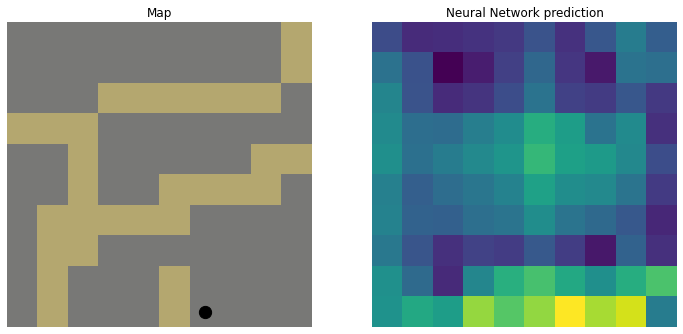

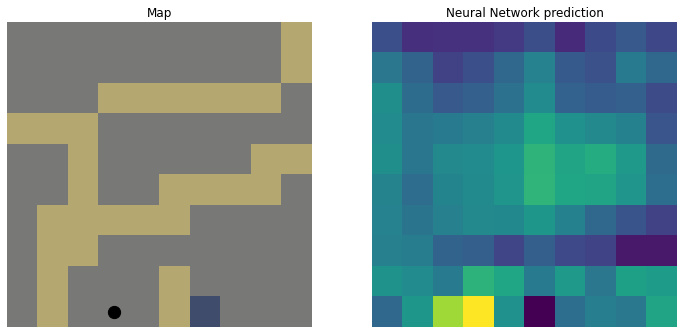

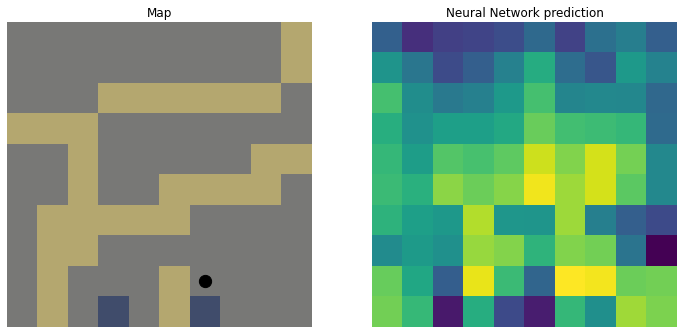

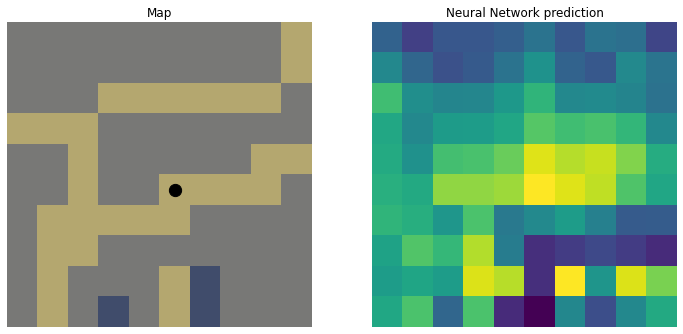

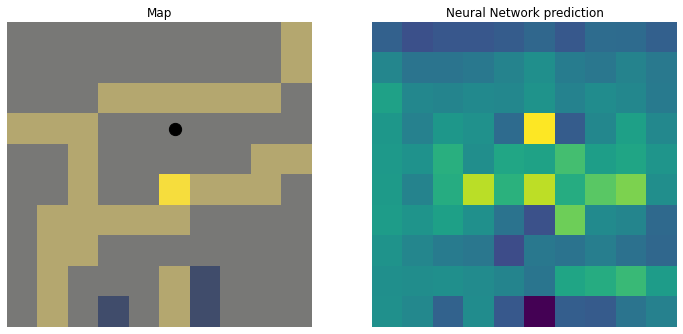

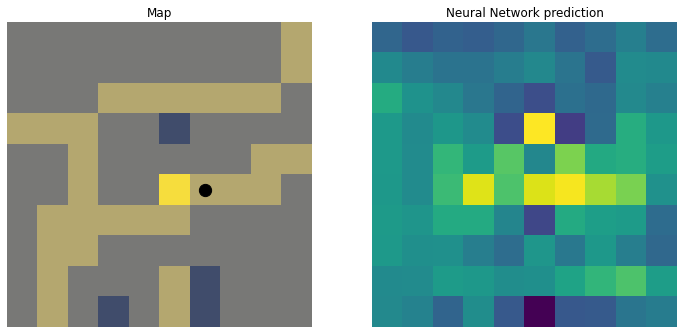

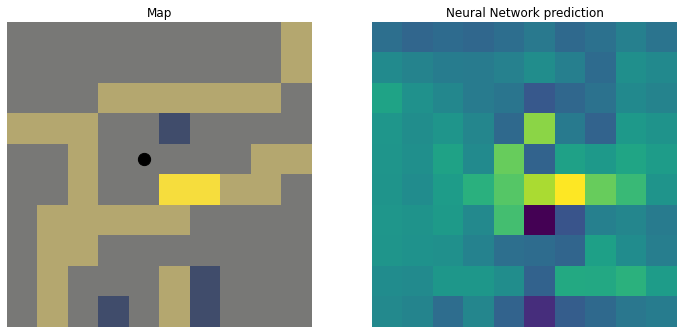

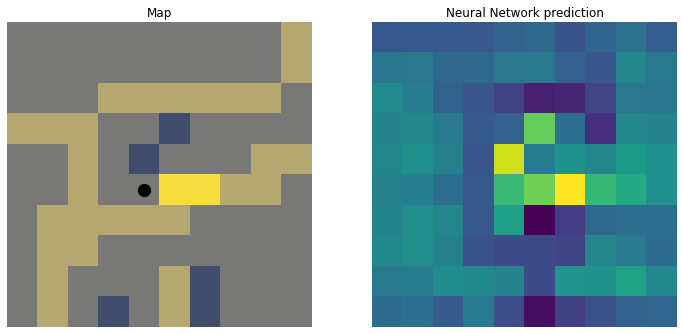

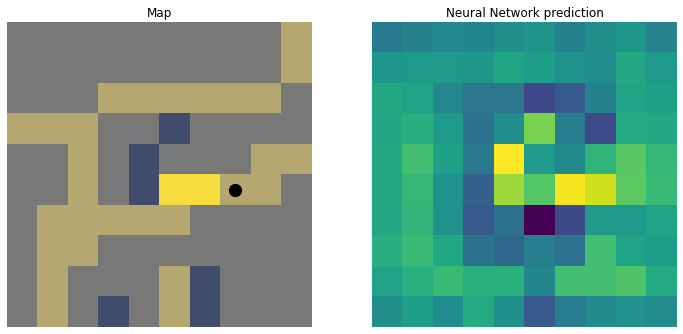

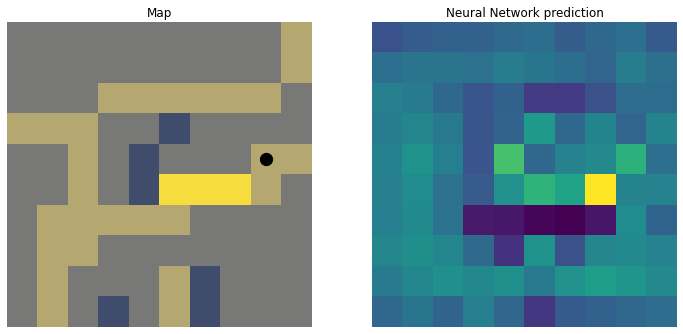

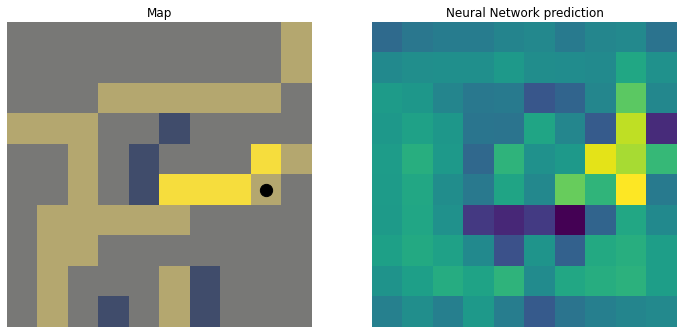

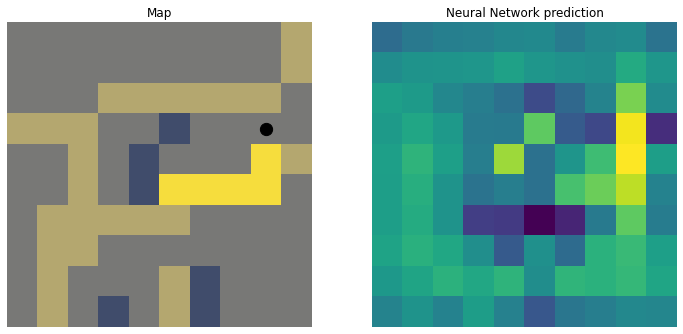

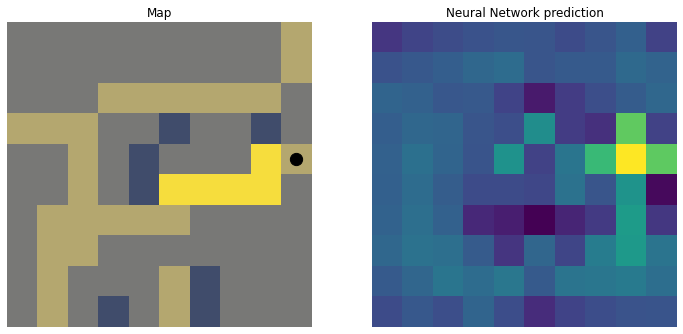

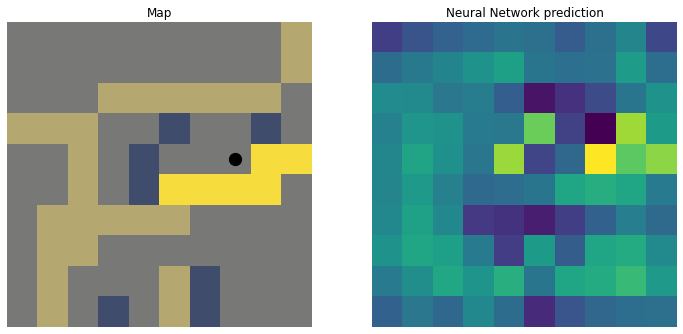

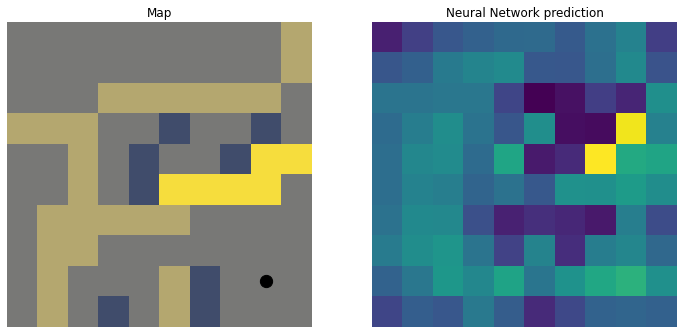

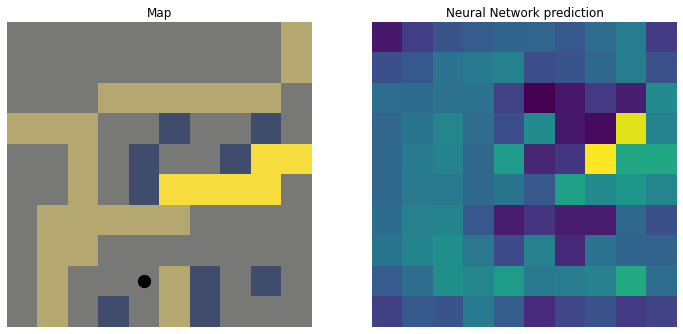

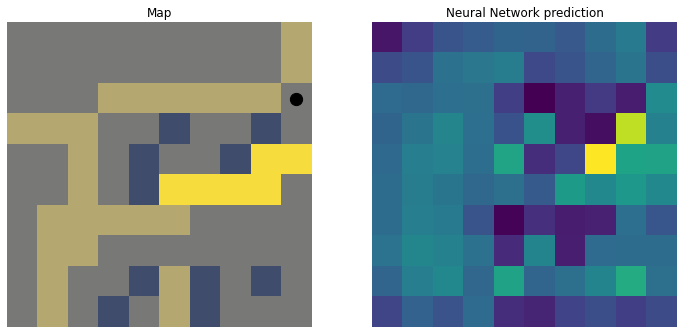

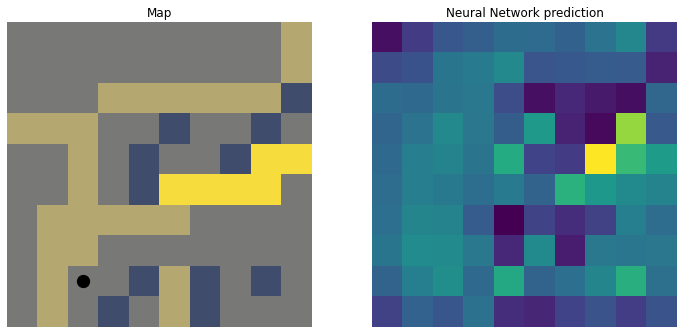

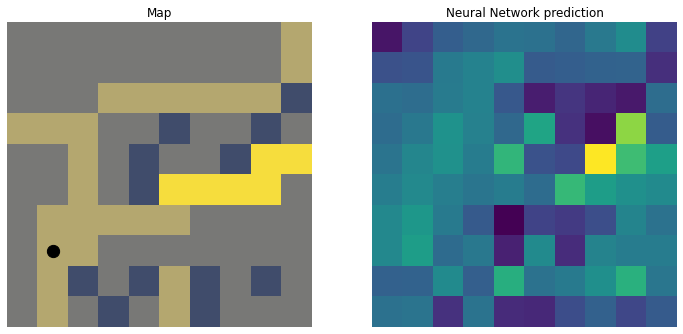

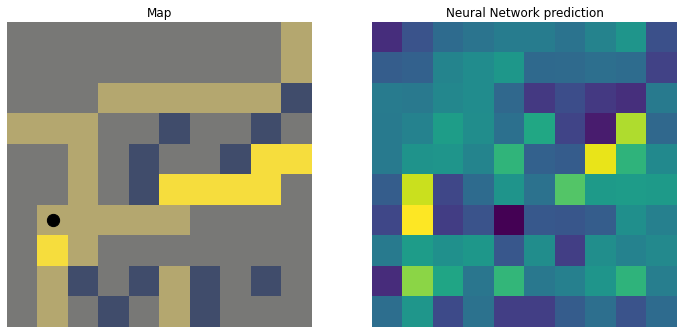

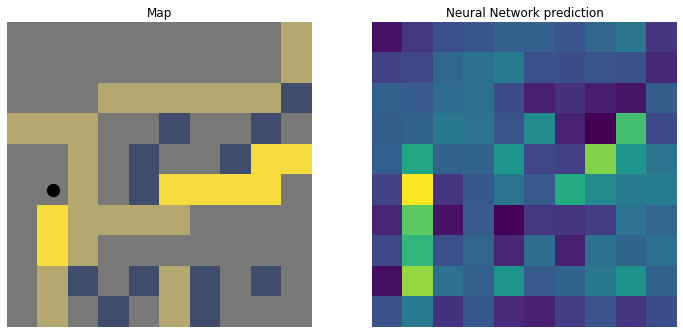

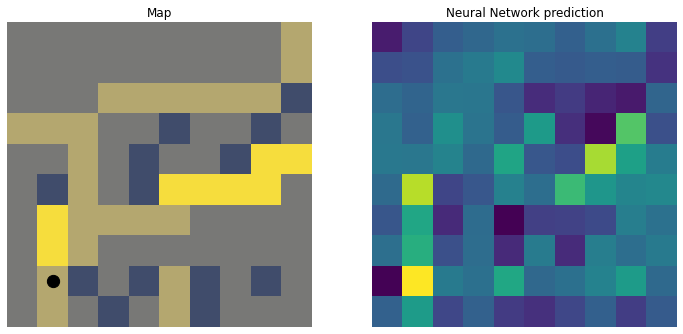

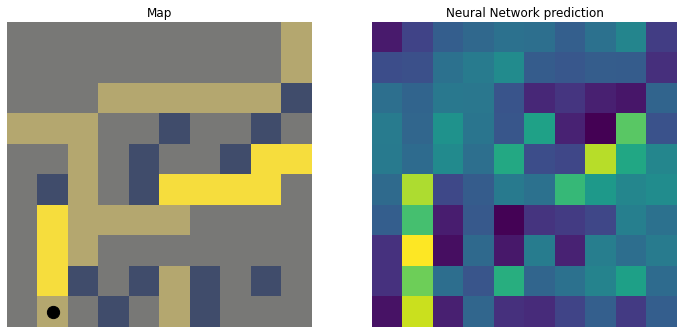

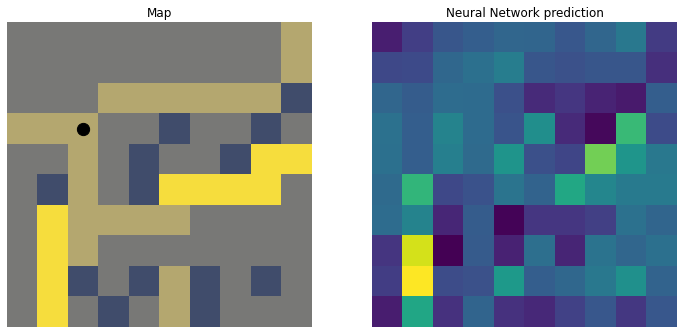

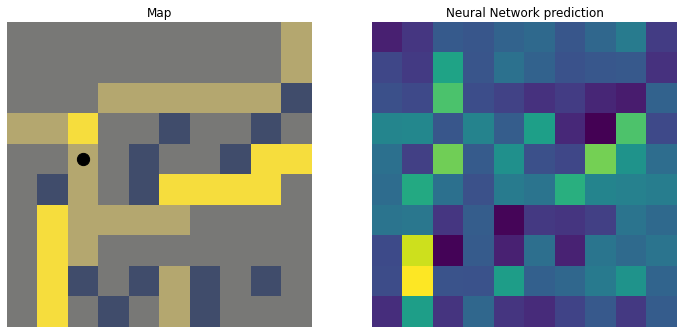

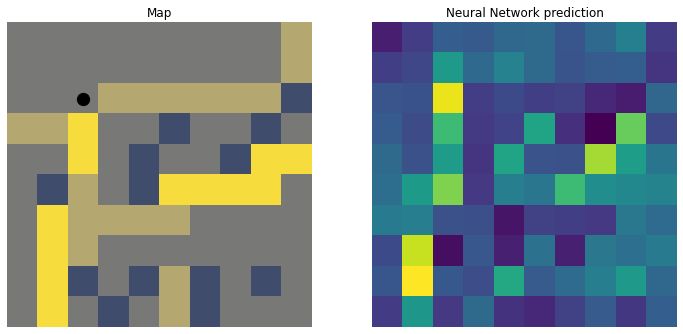

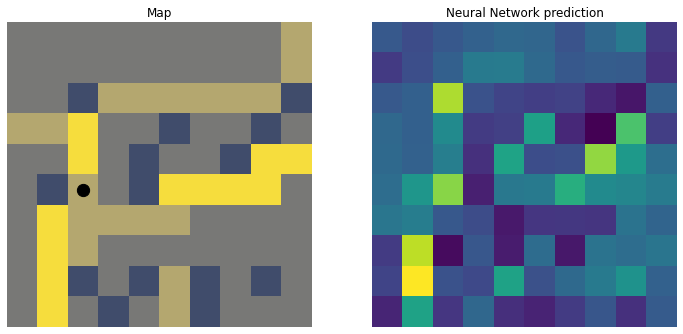

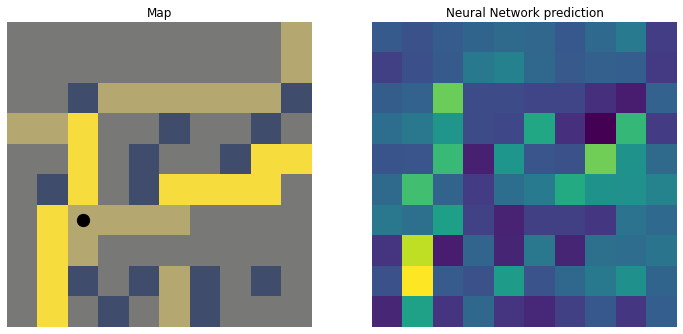

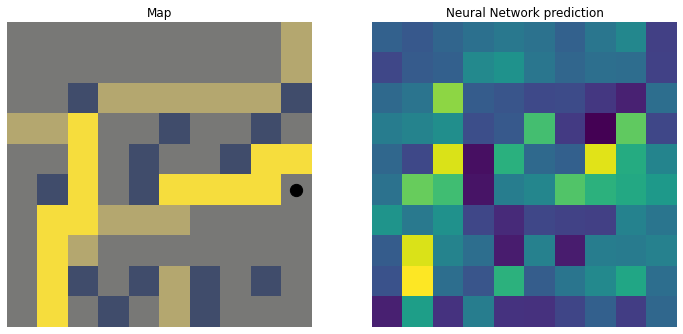

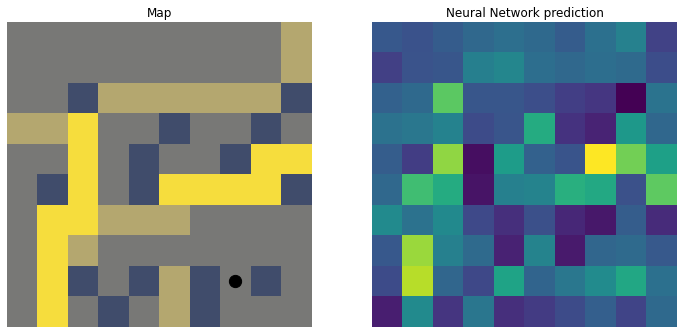

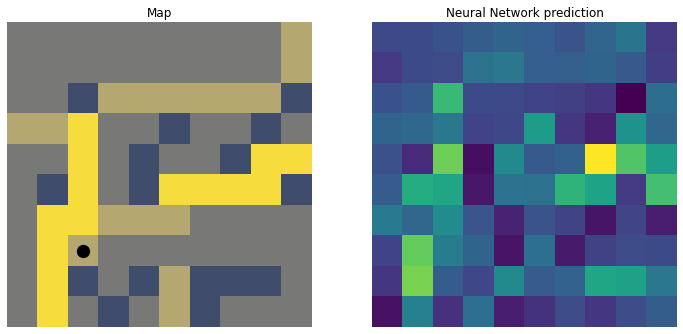

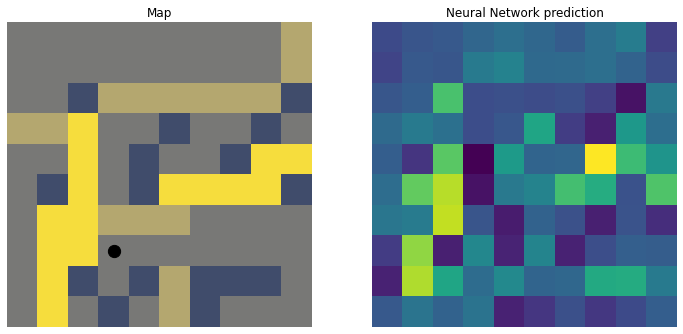

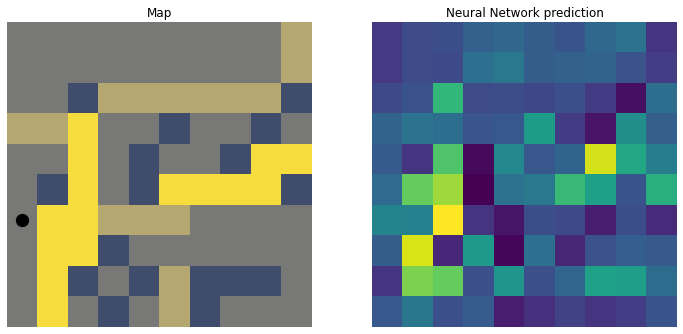

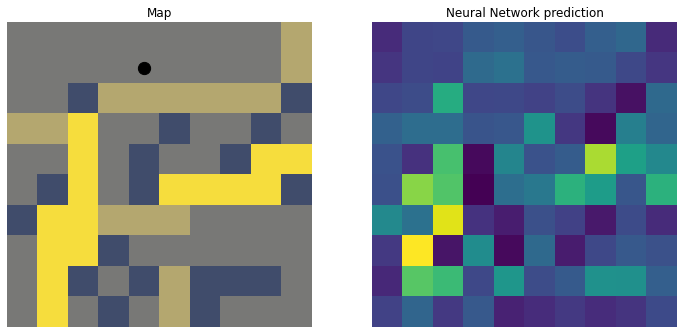

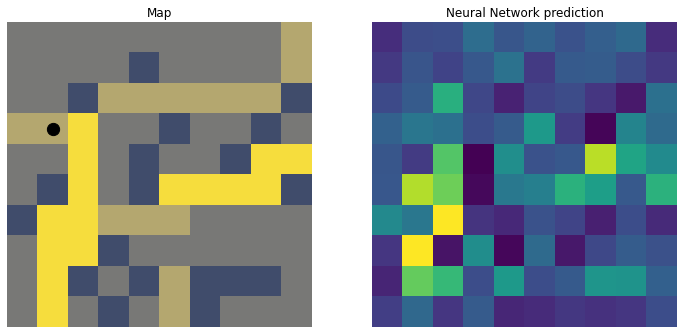

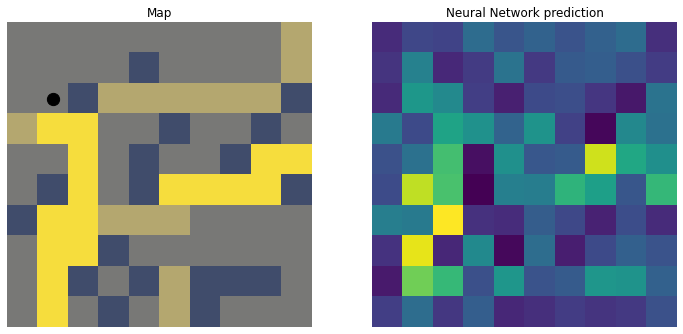

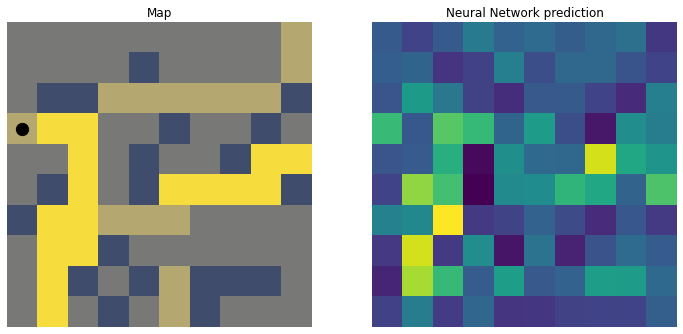

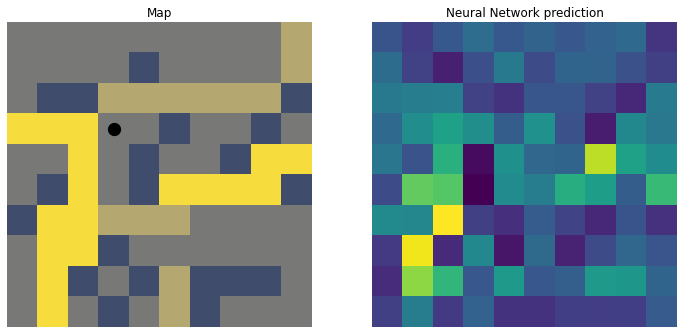

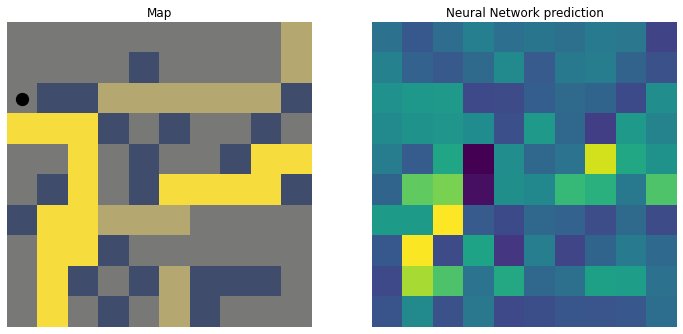

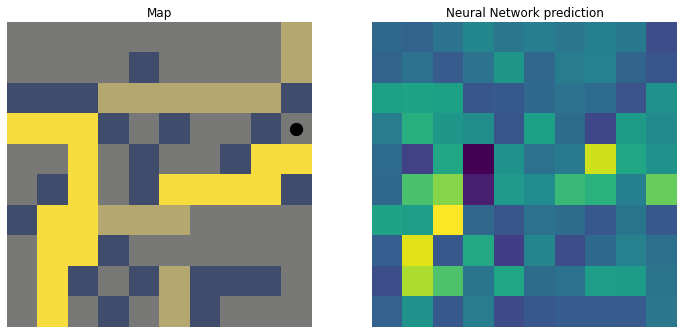

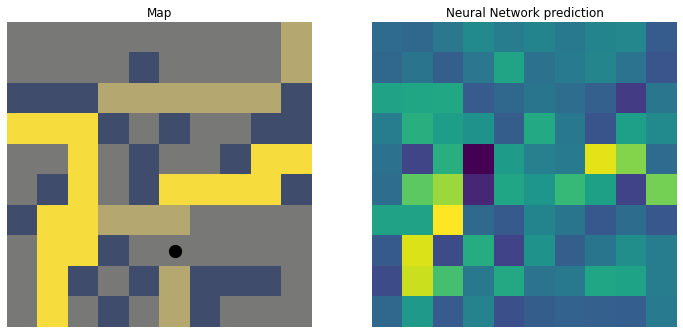

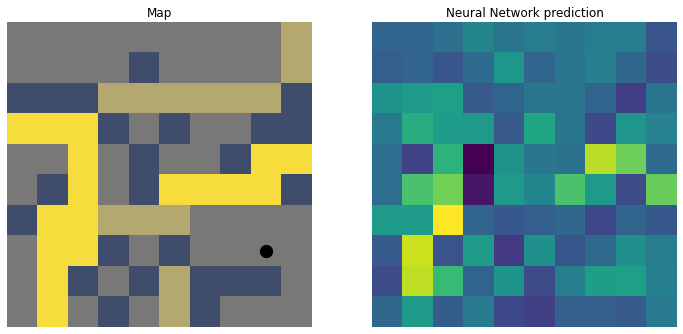

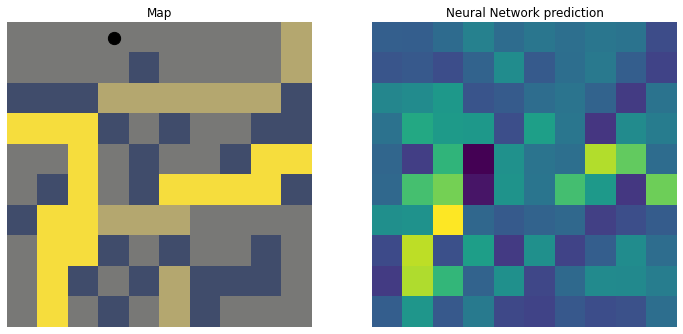

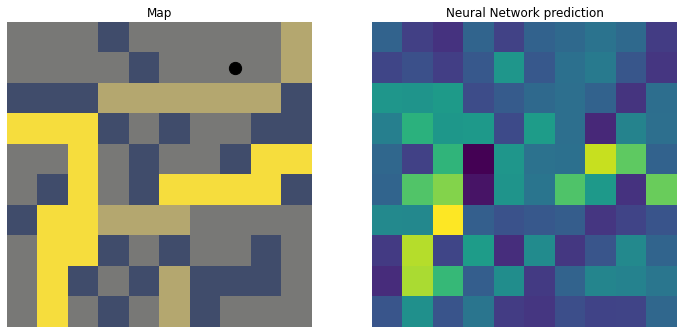

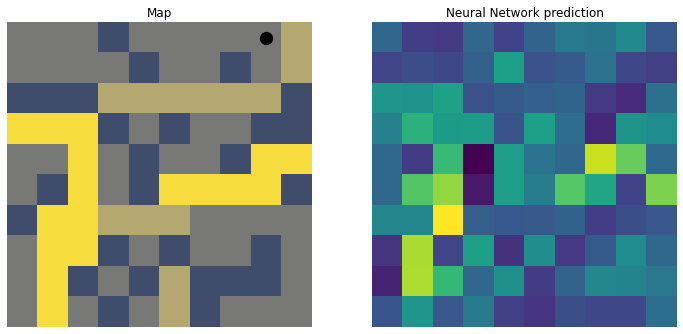

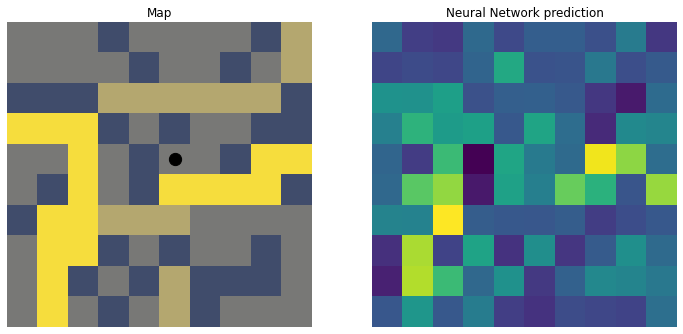

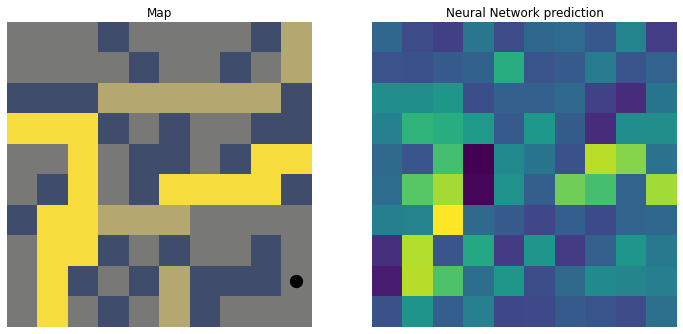

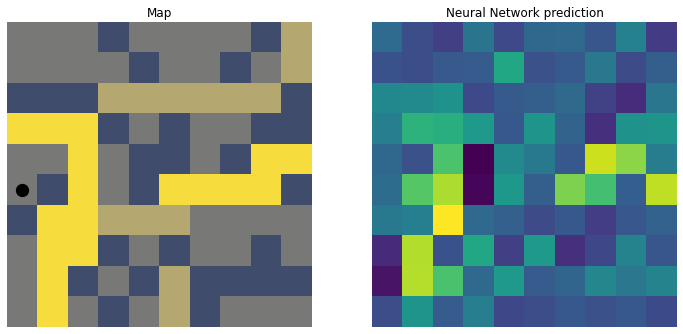

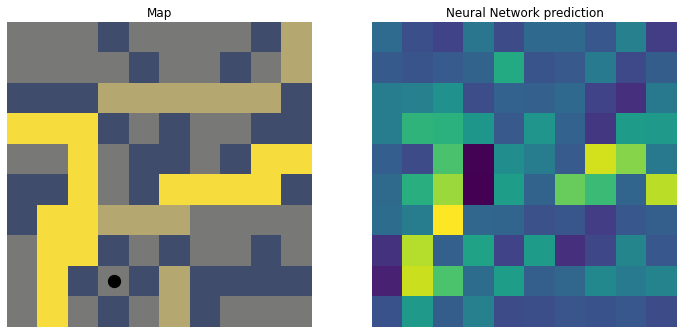

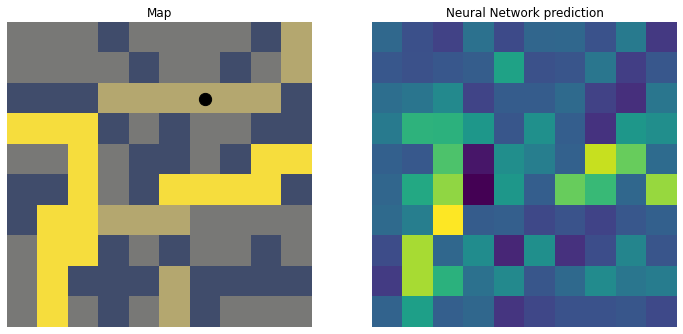

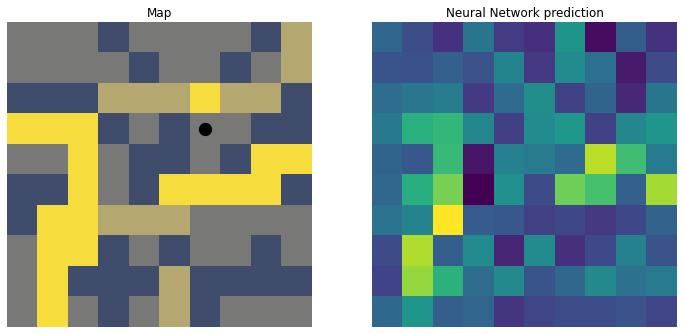

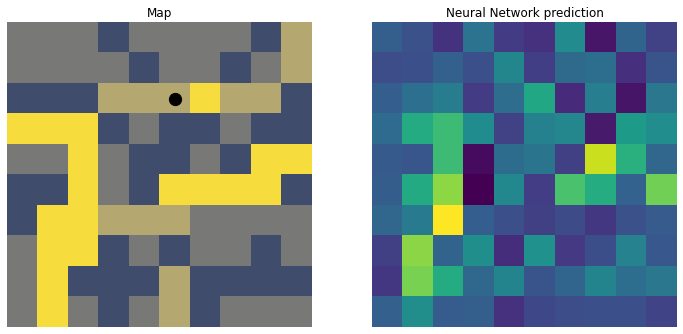

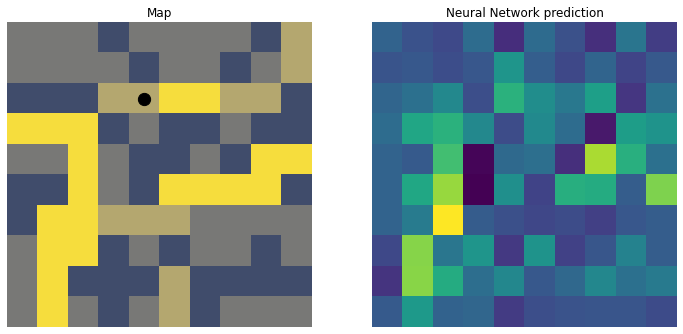

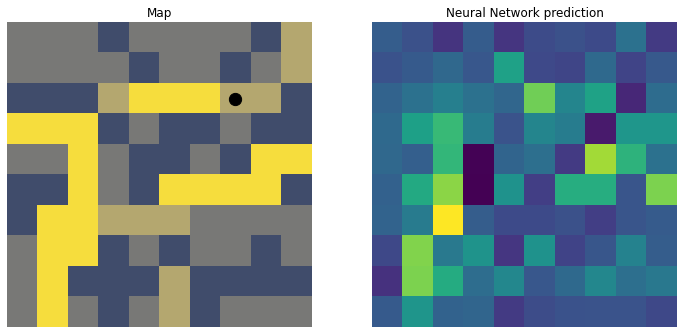

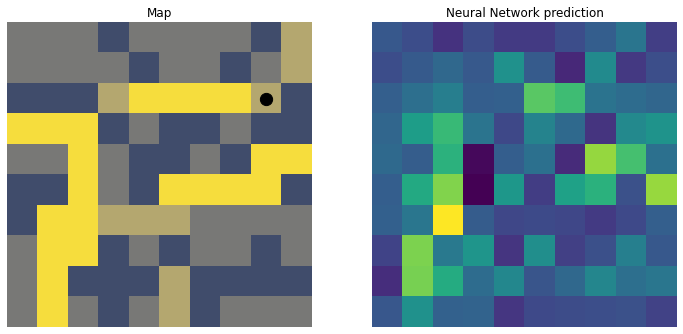

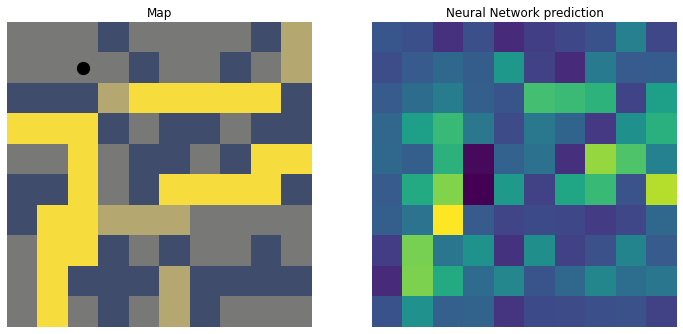

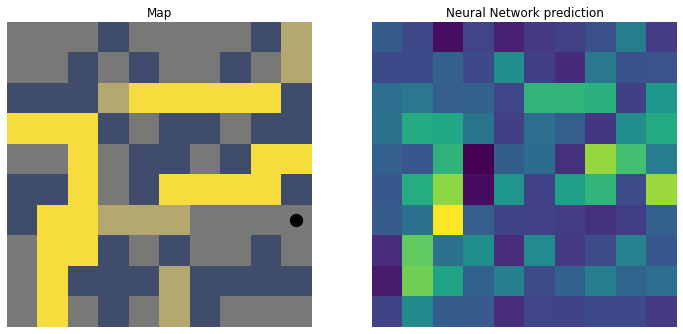

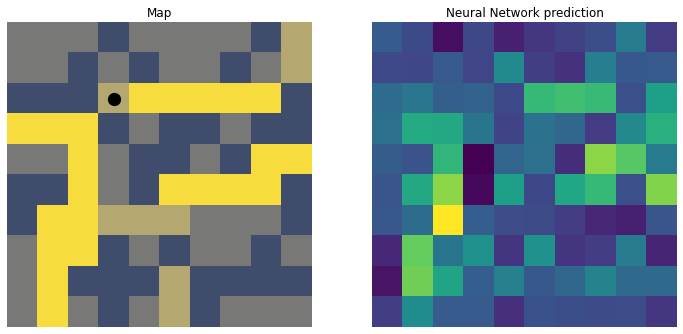

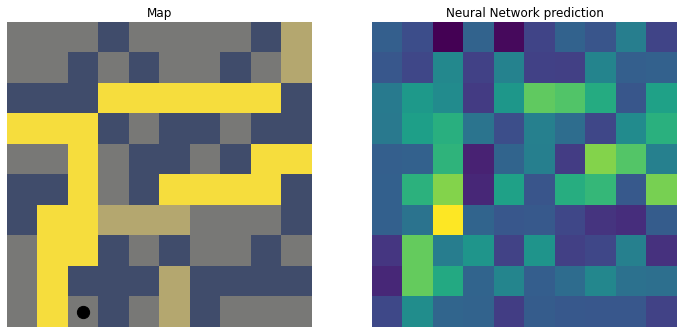

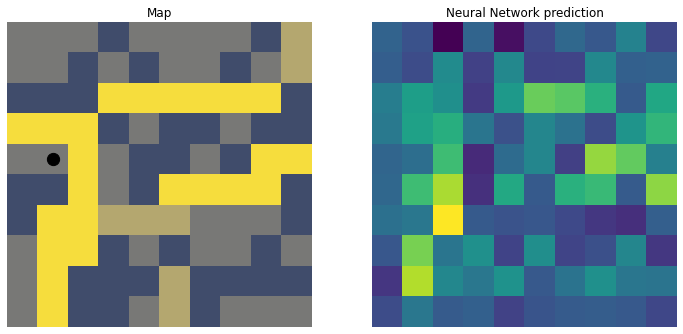

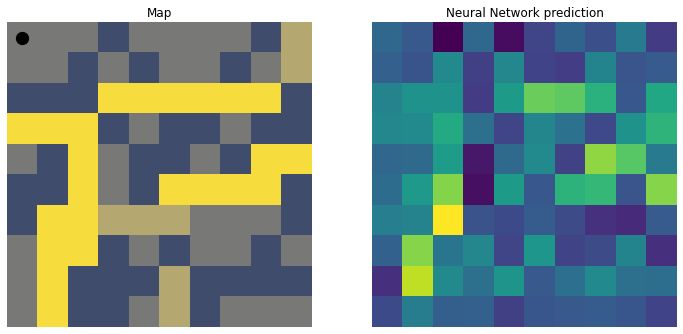

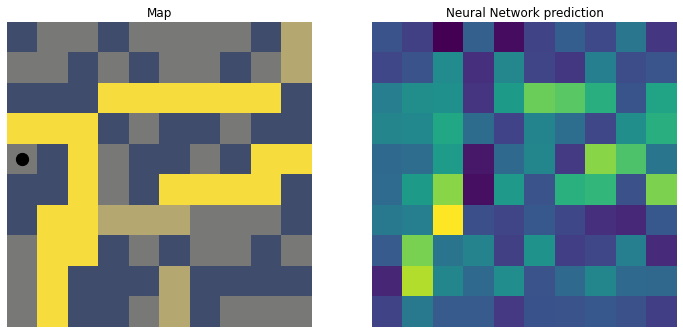

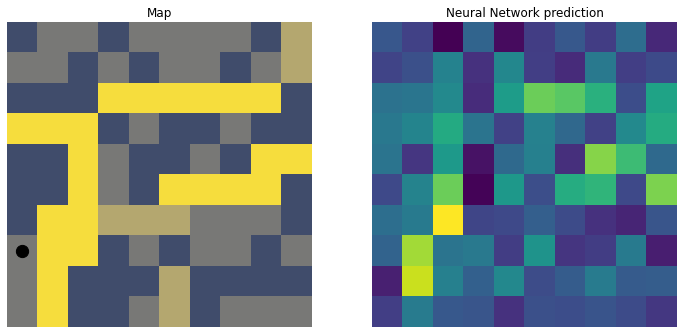

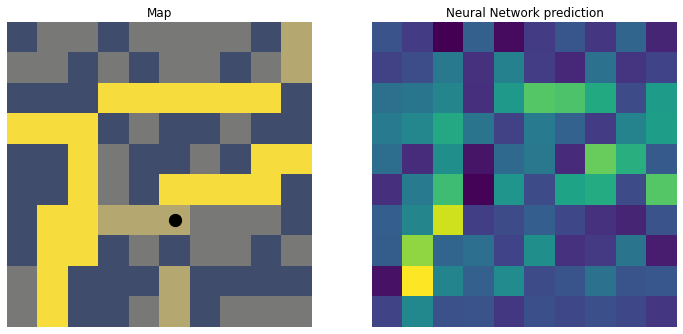

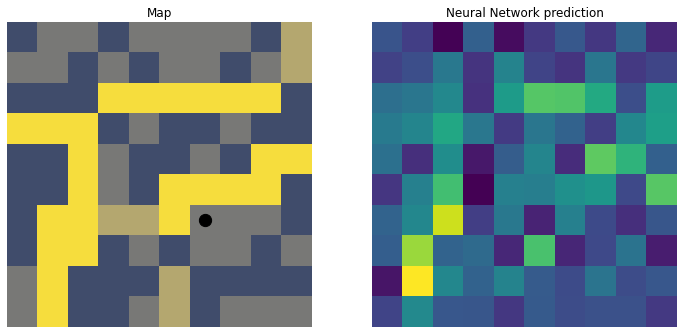

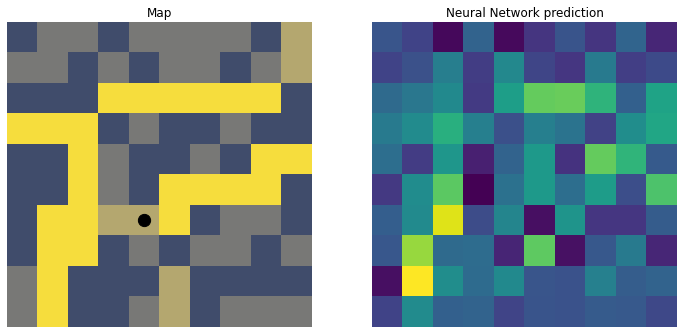

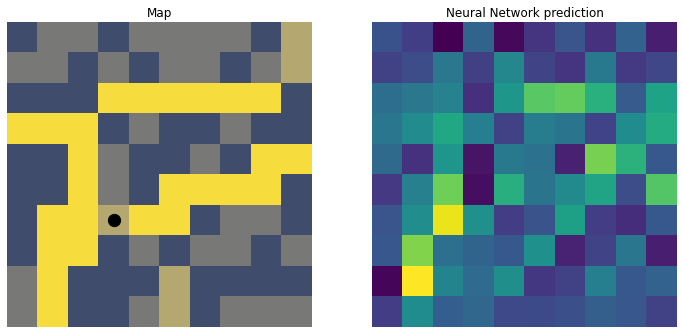

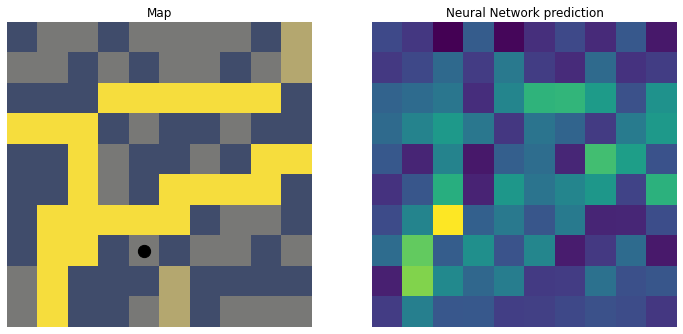

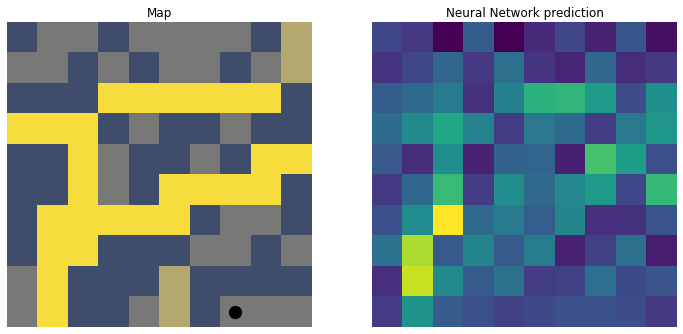

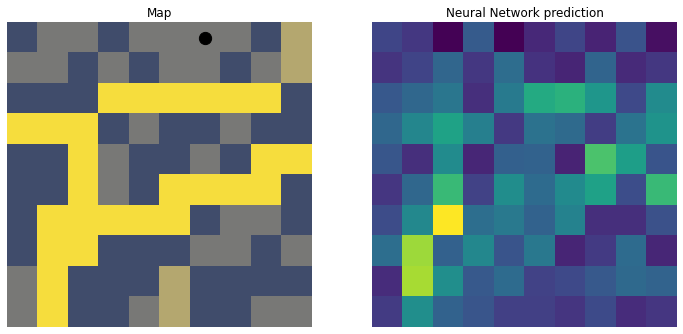

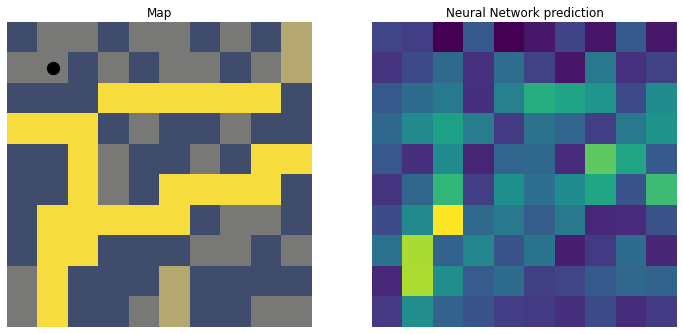

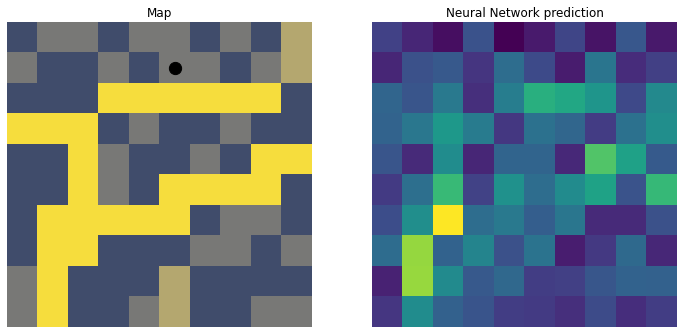

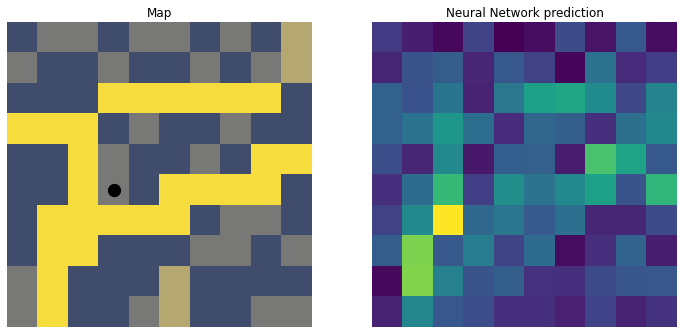

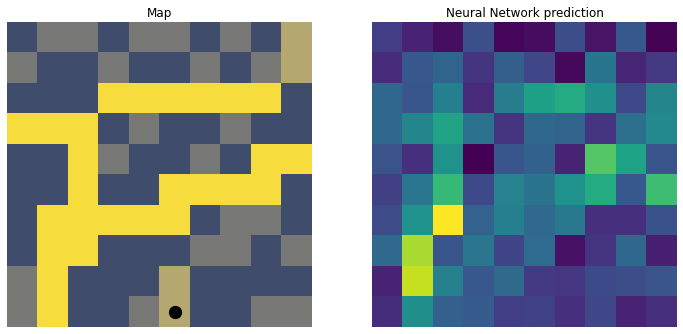

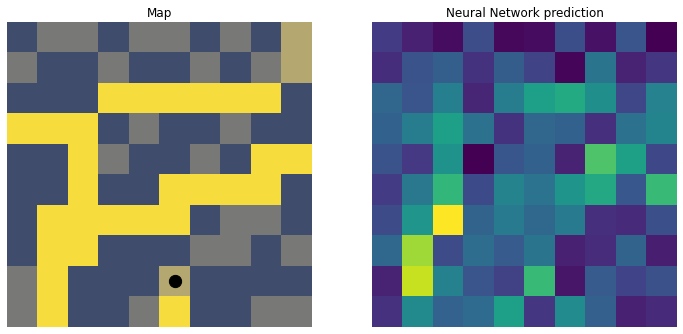

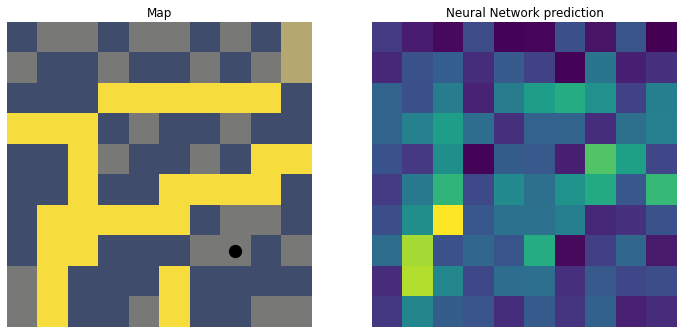

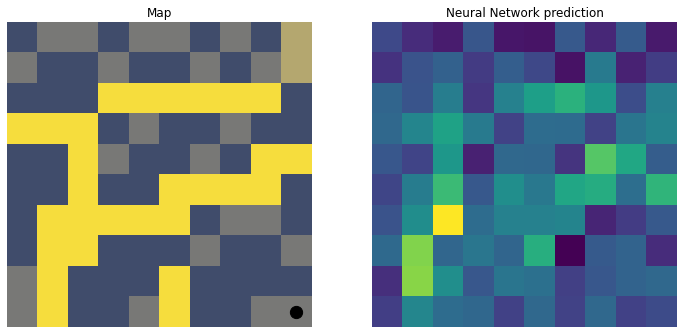

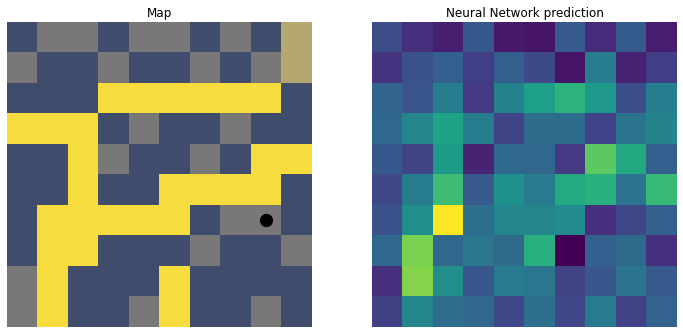

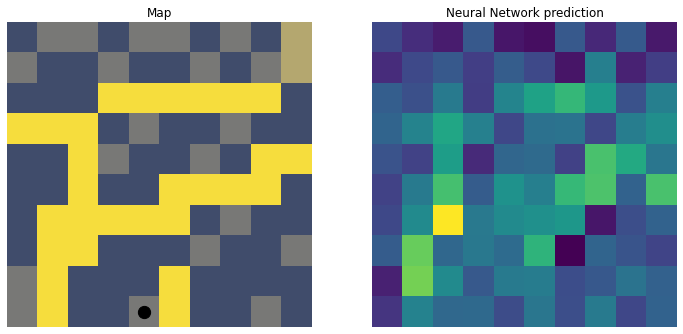

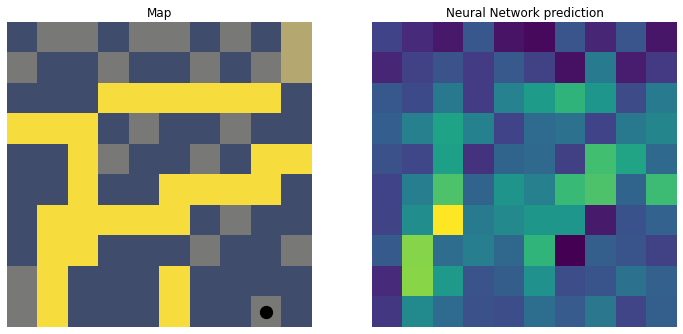

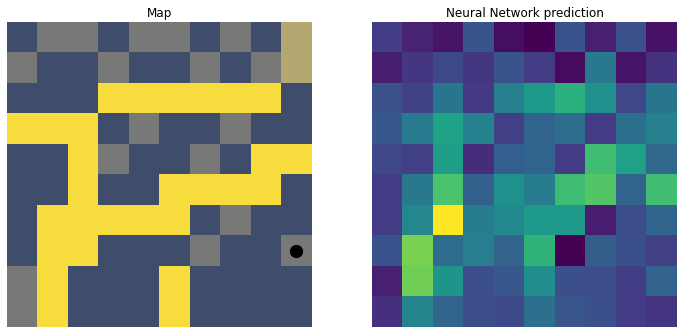

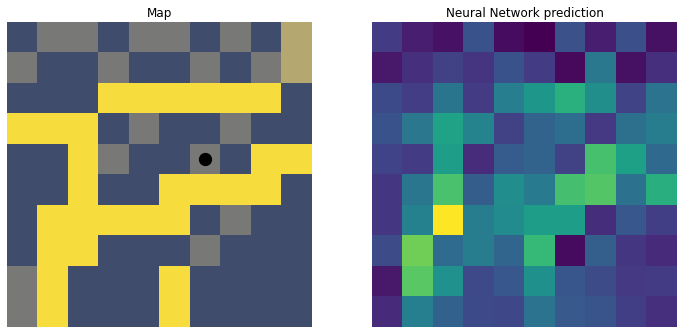

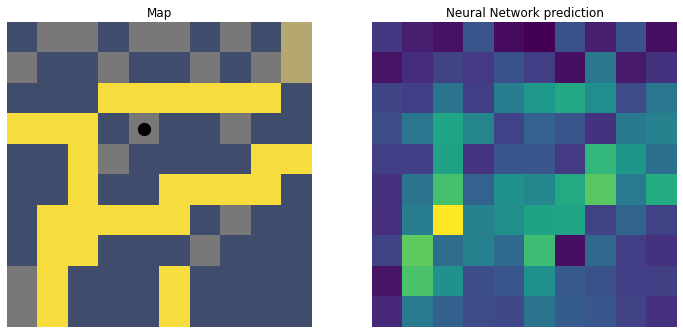

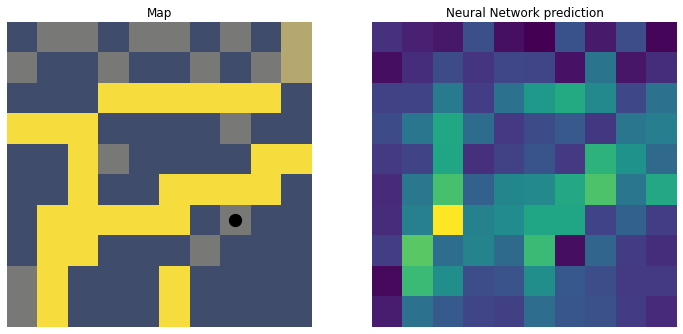

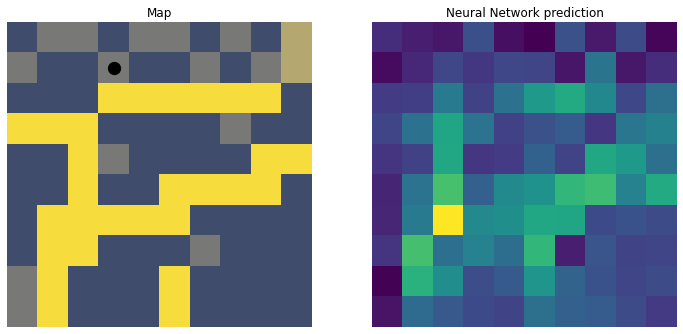

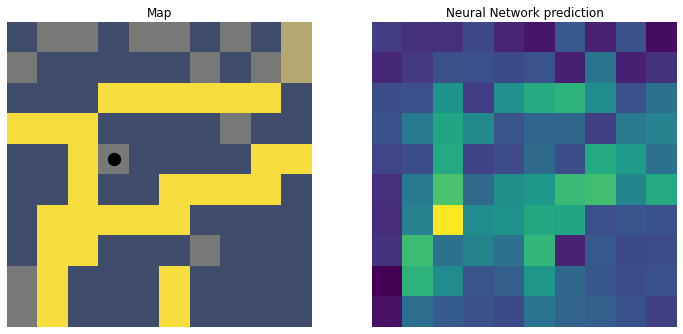

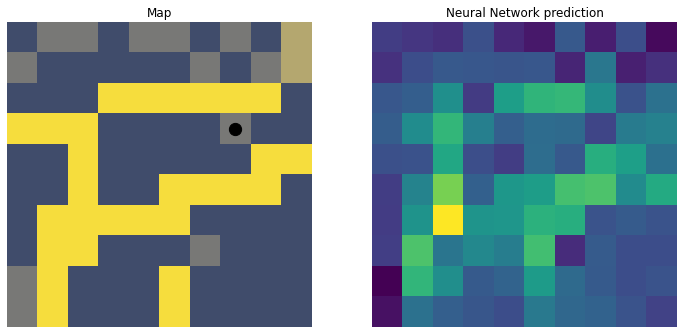

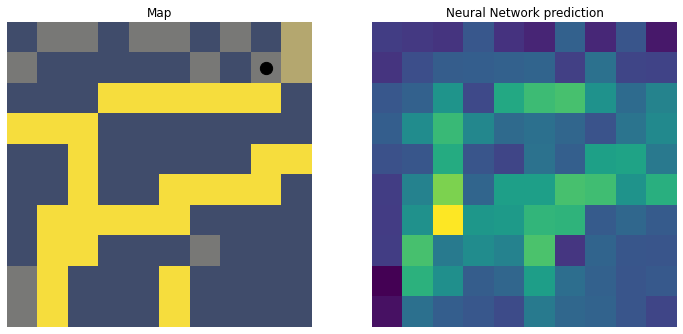

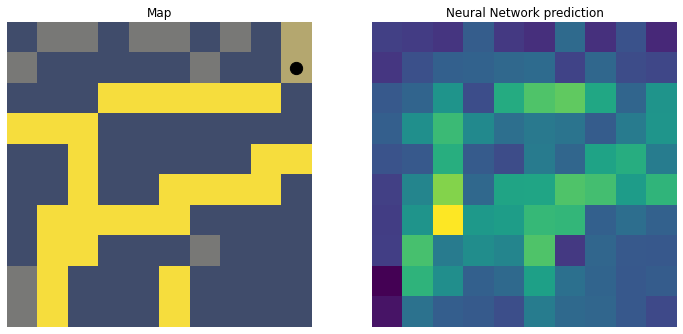

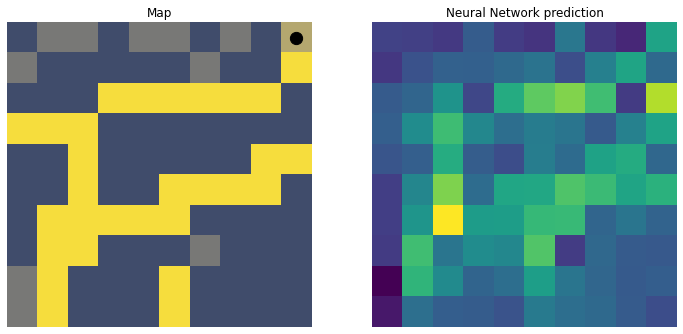

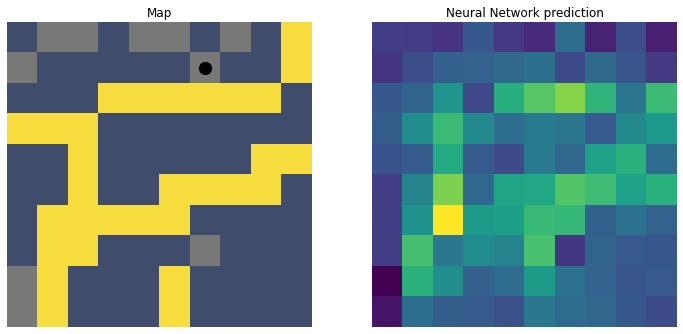

In [10]:
# gegeben: sea, model
det = np.zeros((10,10))
sea = create_sea(100)
##det = create_detection()
i,j = [],[]
from vidcapture import *
vc = vidcapture('F:/$Daten/vidcaptures/battleships qlearning/frame%05d.png')

while True:
    # Welchen Detektieren??
    x = encode_x(sea, det)
    net.predict(x)
    p = net.p
    p = t2np(p)[0,:,:,0]
    i, j = argmax2d(p-det*999999)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    ax1.title.set_text('Map')
    ax2.title.set_text('Neural Network prediction')
    ax1.axis('off')
    #ax1.imshow(visualize(sea, det), vmin=0., vmax=3.)
    plot_sea(sea, det, ax1)
    ax1.scatter(j, i, c='black', alpha=1, s=150)
    ax2.axis('off')
    ax2.imshow(p)
    #plt.title(text)
    vc.capture()
    plt.show()
    
    if np.sum(det*sea) >= np.sum(sea): break
        
    det[i,j] = 1

In [11]:

# Viele Spiele spielen und score sehen
from bs_gameclass import *

rs = []
for _ in trange(100):
    s = GameState()
    h = create_sea()
    r = 0
    while not GameClass.getEnded(s):
        prob = net.predict(encode_x(s.sea, s.det))
        prob[s.det==1] = 0
        ij = argmax2d(prob)
        s = GameClass.getNextState(s, ij, h)
        r += h[ij]*np.mean(1-s.det)
        #plot_state(s)
        #plt.show()
    rs.append(r)

  0%|          | 0/100 [00:00<?, ?it/s]

(19.3926, 1.0594183498505205)

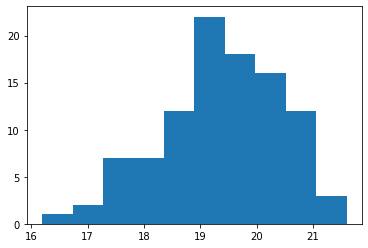

In [12]:
import seaborn as sns
plt.hist(rs)
np.mean(rs), np.std(rs)